In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

# get size

In [346]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

inout = []
for i in mdb.index:
    for ii in range(len(mdb.zgrism_hci[i])//2):
        if mdb.zgrism_hci[i][2*ii] <= mdb.zgrism[i] <= mdb.zgrism_hci[i][2*ii+1]:
            if(mdb.zgrism_hci[i][2*ii+1] - mdb.zgrism_hci[i][2*ii]) /( 2 * (1 + mdb.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
mdb['inout'] = inout
mdb = mdb.query('inout == "i"')

mdbS = mdb.query('n_f < 1')
mdbMC = mdb.query('n_f < 2 and zgrism < 1.75 and lmass > 10')
mdbMCS = mdb.query('n_f < 1 and zgrism < 1.75 and lmass > 10')
mdb = mdb.query('n_f < 2')


# SF_db = pd.read_pickle('../Casey_data/SF_db.pkl')
# sfdb = SF_db.query('AGN != "AGN" and Z > 0')

In [347]:
len(mdbS),len(mdbMC),len(mdbMCS),len(mdb),

(70, 110, 53, 131)

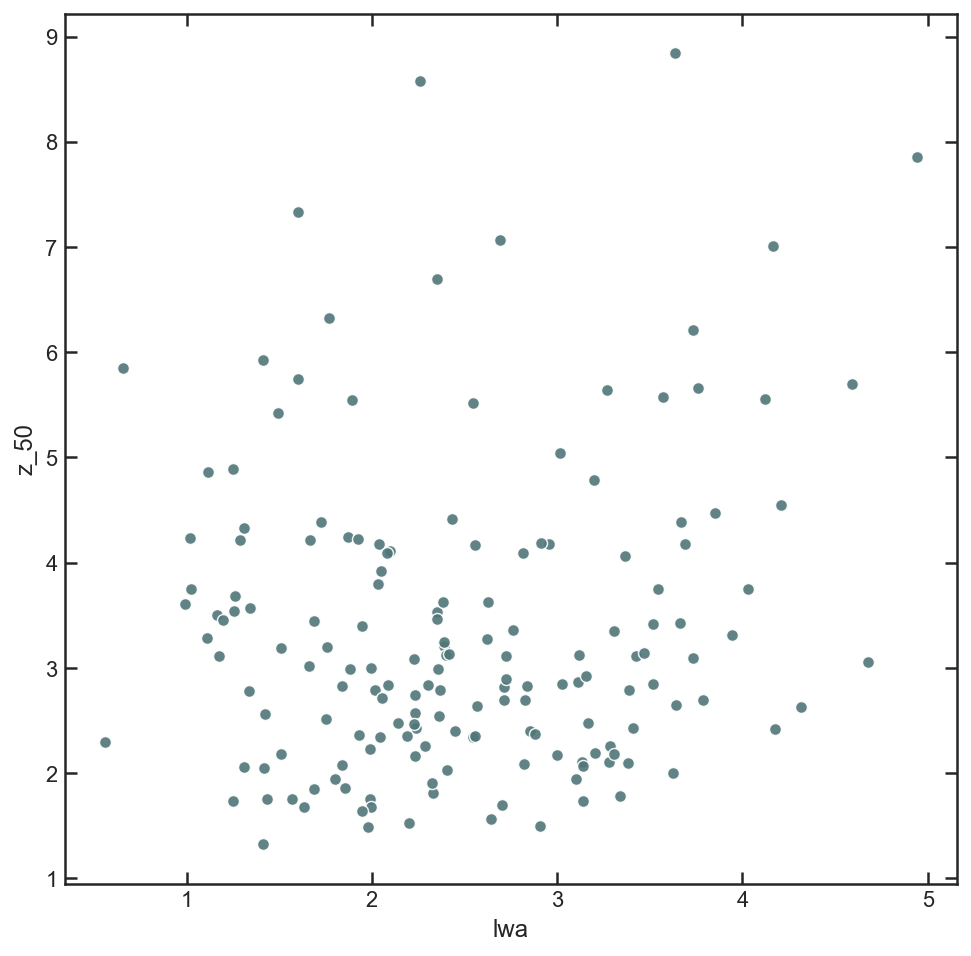

In [324]:
plt.figure(figsize=[8,8])
ax = plt.subplot()
    
sea.scatterplot(morph_db.lwa, morph_db.z_50, color = '#507678',
                 sizes=(20, 200),legend=False, ax=ax, alpha = 0.9)

In [29]:
set(mdb.Sigma1)

{159389162.98523176,
 172516363.87593296,
 187592980.48945186,
 199344013.5721188,
 205810090.4262931,
 251476991.87060684,
 259260945.3562231,
 275611103.3880777,
 297854322.83483297,
 309568304.4812084,
 344580693.8242555,
 382509708.6586167,
 450838402.24841917,
 482664406.82798076,
 488055641.97515655,
 634994852.8932505,
 635242330.2551467,
 644091513.8954474,
 675851154.6534722,
 817190873.647565,
 884072912.8902397,
 918176466.1805372,
 949406579.4388852,
 950102163.4382695,
 982537740.8172737,
 985978372.1420127,
 1083781001.6109436,
 1120763960.2266386,
 1158329158.075731,
 1189298065.9034104,
 1197480074.189542,
 1201895456.8330731,
 1235652619.6635065,
 1298610803.5782413,
 1326706997.529891,
 1401847903.139181,
 1454332366.1392229,
 1466343418.3745105,
 1477614896.0328138,
 1506943623.1763105,
 1526287443.9814665,
 1553106224.384349,
 1592993816.3824944,
 1655960347.6554296,
 1664524914.421089,
 1710267024.7561886,
 1745472874.8697858,
 1767787841.62858,
 1812531640.1944911

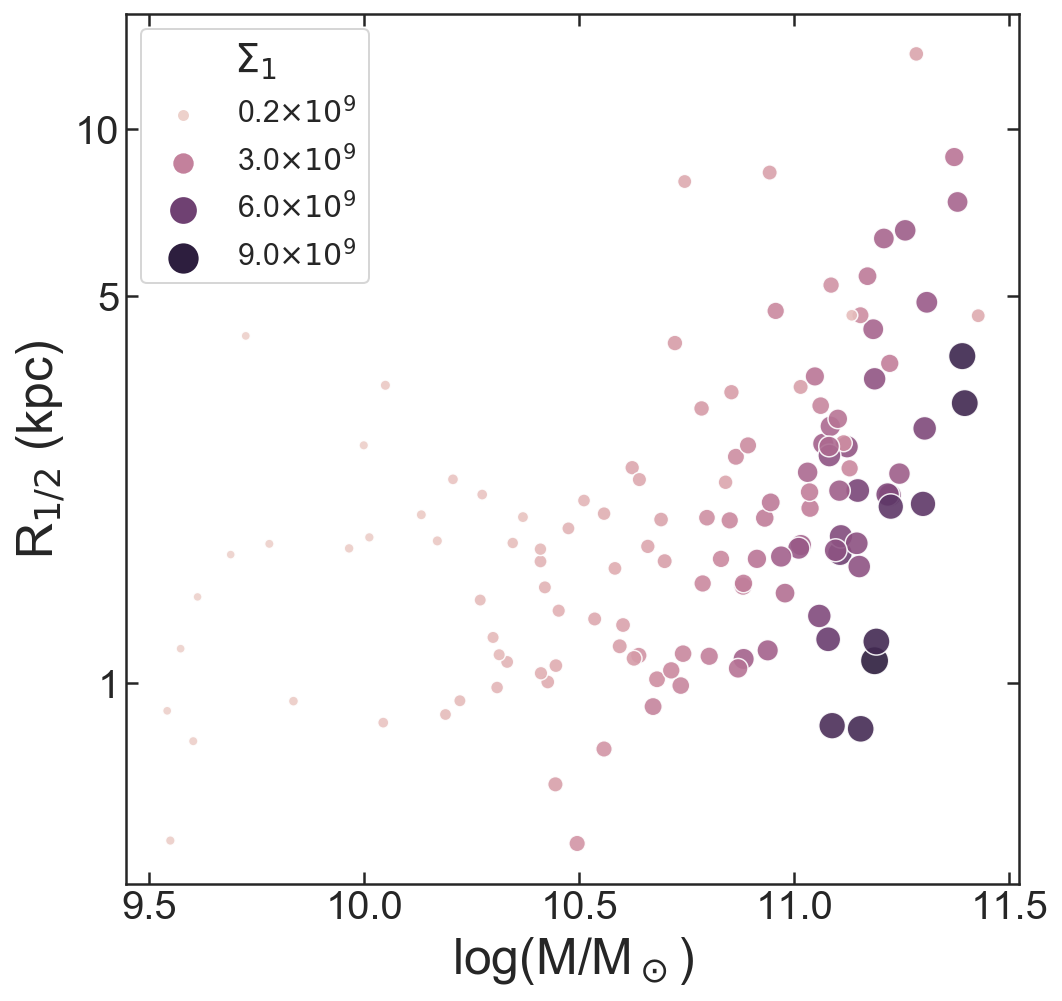

In [50]:
plt.figure(figsize=[8,8])
ax = plt.subplot()
    
g = sea.scatterplot(mdb.lmass, np.log10(mdb.Re), color = '#507678',
                hue = mdb.Sigma1, 
                size= mdb.Sigma1,
                sizes=(20, 200),legend='brief', ax=ax, alpha = 0.9)

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles[1:], ['0.2$\\times 10^9$','3.0$\\times 10^9$','6.0$\\times 10^9$','9.0$\\times 10^9$'],title = '$\Sigma_1$', fontsize = 15)
ax.get_legend().get_title().set_fontsize('20')

   
plt.yticks([np.log10(1),np.log10(5),np.log10(10)],[1,5,10])
plt.ylabel('R$_{1/2}$ (kpc)', fontsize=25)
plt.xlabel('log(M/M$_\odot$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/r_lm.pdf', bbox_inches = 'tight')

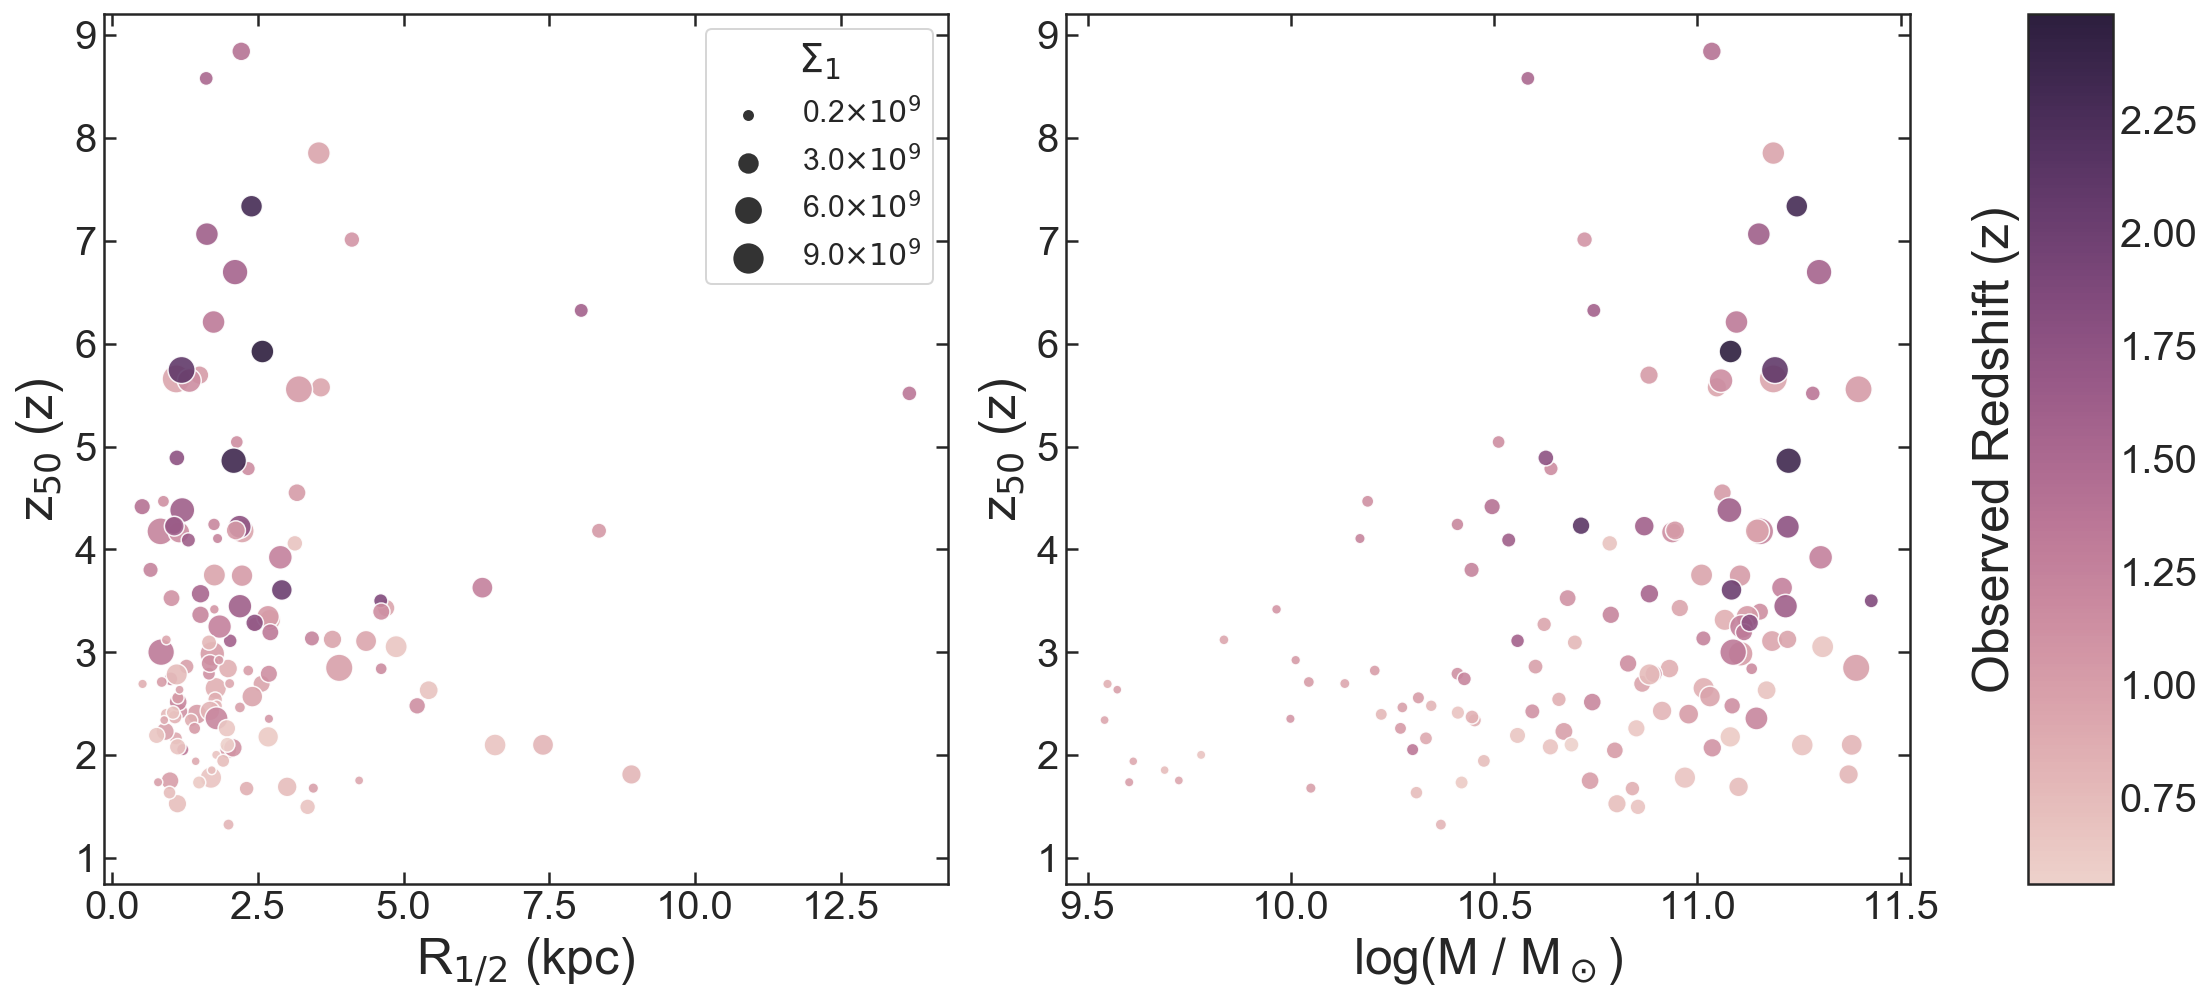

In [62]:
gs = gridspec.GridSpec(1,3,width_ratios=[1,1,.1])
plt.figure(figsize=[18,8])
ax1 = plt.subplot(gs[0])

sea.scatterplot(mdb.Re, mdb.z_50, color = '#507678',
                size=mdb.Sigma1, hue=mdb.zgrism,sizes=(20, 200),legend='brief', ax=ax1, alpha = 0.9)

plt.xlabel('R$_{1/2}$ (kpc)', fontsize=25)
plt.ylabel('z$_{50}$ (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles[7:], ['0.2$\\times 10^9$','3.0$\\times 10^9$','6.0$\\times 10^9$','9.0$\\times 10^9$'],title = '$\Sigma_1$', fontsize = 15)
ax1.get_legend().get_title().set_fontsize('20')
ax1.set_ylim(0.75,9.2)

ax2 = plt.subplot(gs[1])
s2 = sea.scatterplot(mdb.lmass, mdb.z_50,
                size=mdb.Sigma1, hue=mdb.zgrism,sizes=(20, 200),legend=False, ax=ax2, alpha = 0.9)
plt.xlabel('log(M / M$_\odot$)', fontsize=25)
plt.ylabel('z$_{50}$ (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylim(0.75,9.2)


ax3 = plt.subplot(gs[2])
cmap = sea.cubehelix_palette(8, as_cmap=True)
norm = mpl.colors.Normalize(vmin=min(mdb.zgrism), vmax = max(mdb.zgrism))
mpl.colorbar.ColorbarBase(ax3, cmap = cmap, norm=norm, orientation='vertical')
ax3.set_ylabel('Observed Redshift (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
ax3.yaxis.set_label_position('left')
plt.savefig('../plots/z50_all.png', bbox_inches = 'tight')

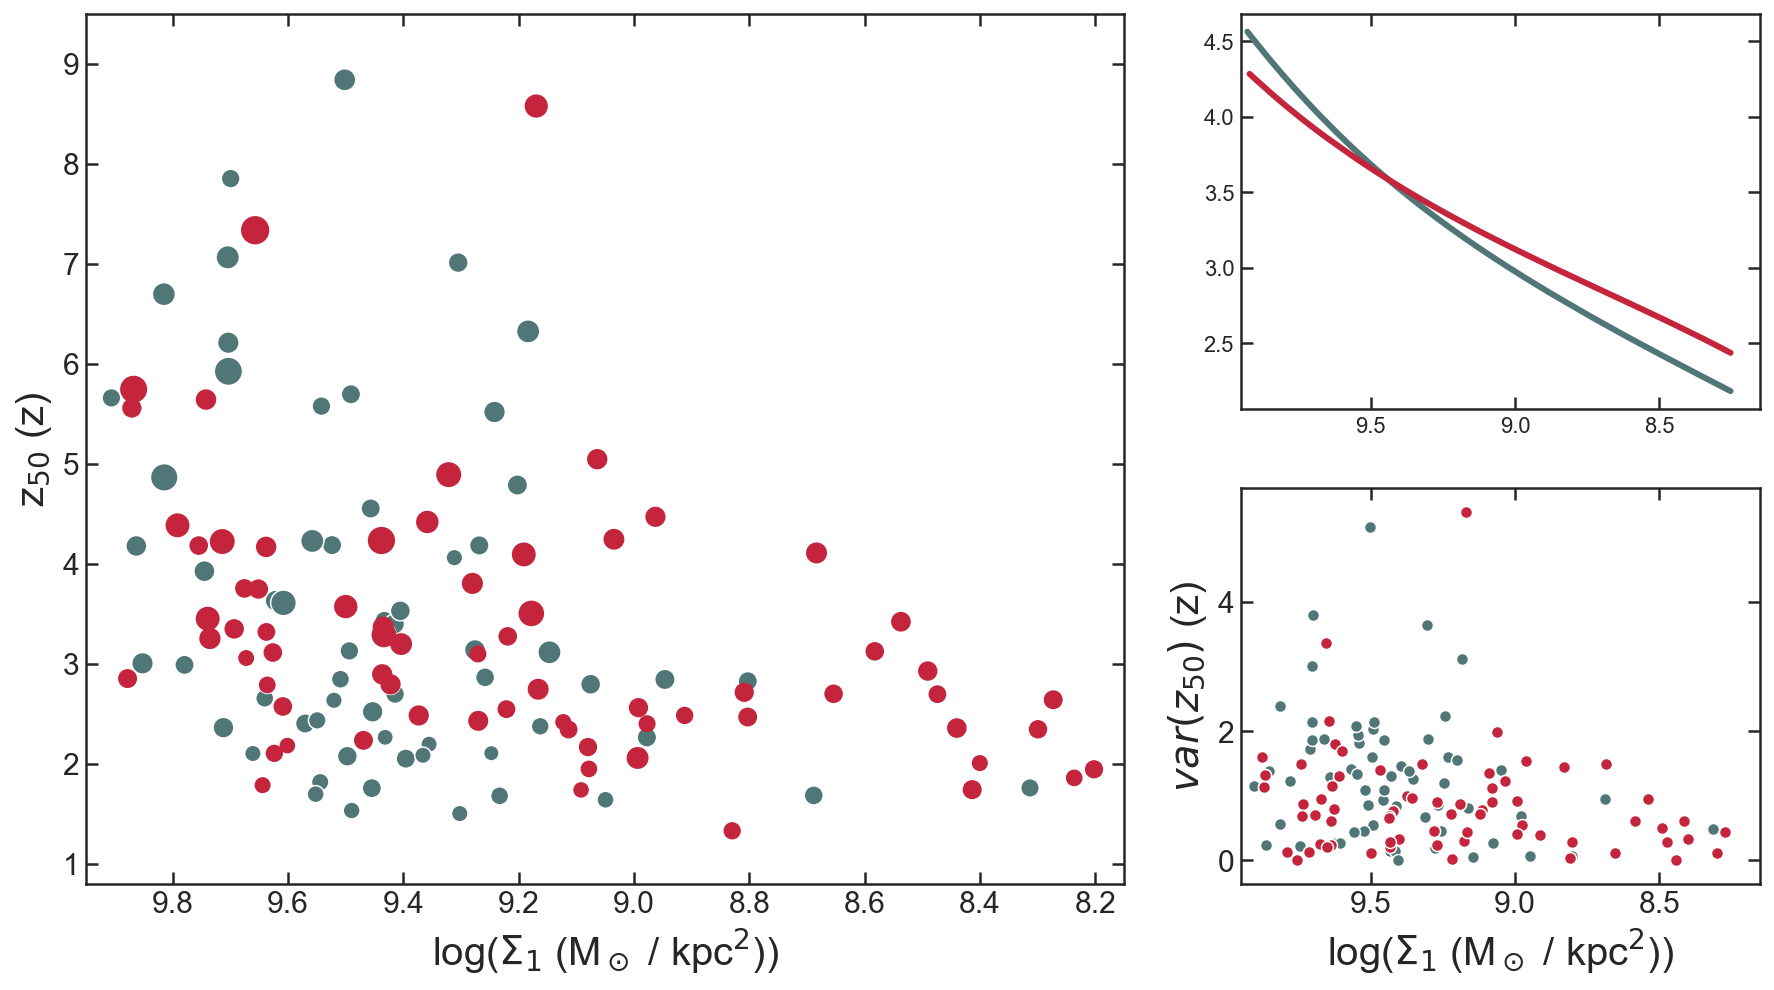

In [401]:
gs = gridspec.GridSpec(2,2,width_ratios=[2,1],hspace=0.2,wspace=0.15)

plt.figure(figsize=[15,8])

ax1 = plt.subplot(gs[:,0])
sea.scatterplot(np.log10(mdb.Sigma1), mdb.z_50,  color = '#507678', 
                size=mdb.zgrism,sizes=(60, 200),legend=False, ax=ax1, label = 'Suspect fit')

sea.scatterplot(np.log10(mdbS.Sigma1), mdb.z_50,  color = '#C4253C', linewidth = 0,
                size=mdbS.zgrism,sizes=(60, 200),legend=False, ax=ax1, label = 'Good fit')
plt.ylim(0.8,9.5)
plt.xlim(9.95,8.15)

plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

ax2 = plt.subplot(gs[0,1])

S1md, S1mn, zmedian, zmean, zvar = Roll_bin_stat(np.log10(mdb.Sigma1.values), mdb.z_50.values,.1)
plt.plot(S1mn,Smooth(S1mn,zmean,0.5), linewidth=3, color='#507678', label = 'Running median')

S1Smd, S1Smn, zmedian, Szmean, zvar = Roll_bin_stat(np.log10(mdbS.Sigma1.values), mdbS.z_50.values,.1)
plt.plot(S1Smn,Smooth(S1Smn,Szmean,0.5), linewidth=3, color='#C4253C', label = 'Running median')
plt.xlim(9.95,8.15)


# Amd,Amn,zmedian, zmean, zvar = Roll_bin_stat(np.log10(mdb.A.values), mdb.z_50.values,.1)
# plt.plot(Amn,Smooth(Amn,zmean,0.3), linewidth=3, color='#EF6D76', label = 'Running median')


# Bmd,Bmn,zmedian, zmean, zvar = Roll_bin_stat(mdb.B.values, mdb.z_50.values,.1)
# plt.plot(Bmn,Smooth(Bmn,zmean,0.5), linewidth=3, color='#EF6D76', label = 'Running median')

ax3 = plt.subplot(gs[1,1])
imed= interp1d(S1mn,Smooth(S1mn,zmean,0.5))
imedS= interp1d(S1Smn,Smooth(S1Smn,Szmean,0.5))

svals = []
svars = []

Ssvals = []
Ssvars = []

for i in mdb.index:
    try:
        svars.append(np.abs(mdb.z_50[i] - imed(np.log10(mdb.Sigma1[i]))))
        svals.append(np.log10(mdb.Sigma1[i]))
    except:
        pass
    
for i in mdbS.index:
    try:
        Ssvars.append(np.abs(mdbS.z_50[i] - imed(np.log10(mdbS.Sigma1[i]))))
        Ssvals.append(np.log10(mdbS.Sigma1[i]))
    except:
        pass
    
sea.scatterplot(svals, svars, color = '#507678', legend=False, label = 'compact', ax=ax3)
sea.scatterplot(Ssvals, Ssvars, color = '#C4253C', legend=False, label = 'compact', ax=ax3)

plt.xlim(9.95,8.15)
# plt.ylim(-0.2,8)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=20)
plt.ylabel('$var(z_{50})$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

# plt.savefig('../plots/compact_b.png', bbox_inches = 'tight')

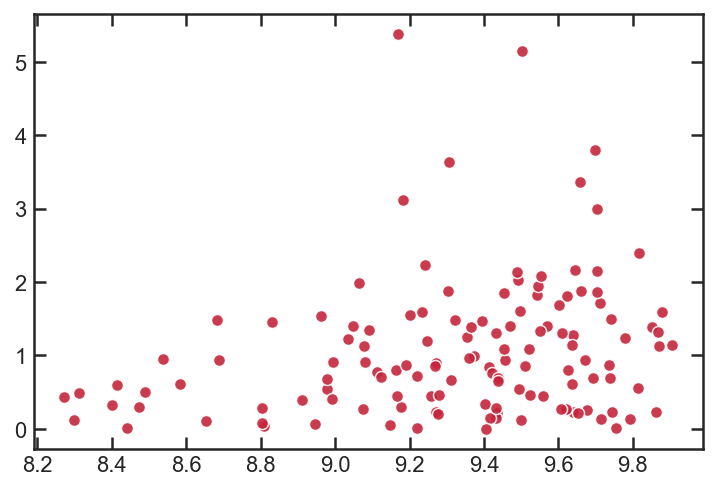

In [306]:
ax2 = plt.subplot(gs[0,1])

Smd, Smn, zmedian, zmean, zvar = Roll_bin_stat(np.log10(mdb.Sigma1.values), mdb.z_50.values,.1)
plt.plot(Smn,Smooth(Smn,zmean,0.5), linewidth=3, color='#EF6D76', label = 'Running median')

Amd,Amn,zmedian, zmean, zvar = Roll_bin_stat(np.log10(mdb.A.values), mdb.z_50.values,.1)
plt.plot(Amn,Smooth(Amn,zmean,0.3), linewidth=3, color='#EF6D76', label = 'Running median')


Bmd,Bmn,zmedian, zmean, zvar = Roll_bin_stat(mdb.B.values, mdb.z_50.values,.1)
plt.plot(Bmn,Smooth(Bmn,zmean,0.5), linewidth=3, color='#EF6D76', label = 'Running median')

(9.95, 8.15)

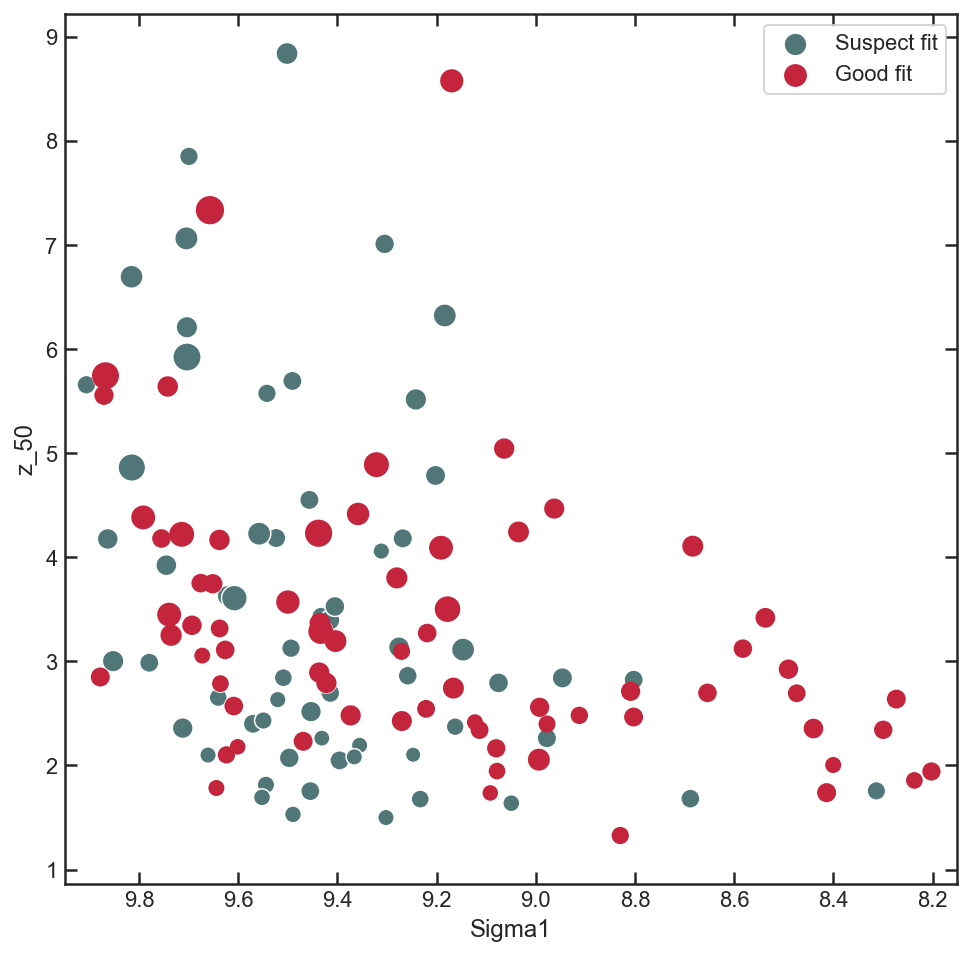

In [386]:
plt.figure(figsize=[8,8])

ax1 = plt.subplot()
sea.scatterplot(np.log10(mdb.Sigma1), mdb.z_50,  color = '#507678', 
                size=mdb.zgrism,sizes=(60, 200),legend=False, ax=ax1, label = 'Suspect fit')

sea.scatterplot(np.log10(mdbS.Sigma1), mdb.z_50,  color = '#C4253C', linewidth = 0,
                size=mdbS.zgrism,sizes=(60, 200),legend=False, ax=ax1, label = 'Good fit')
ax1.legend()
plt.xlim(9.95,8.15)


In [300]:
def Roll_bin_stat(X,Y,bin_size):
    Y = Y[np.argsort(X)]
    X = X[np.argsort(X)]
    
    
    X_med = [] ; X_mean = [] ; binned_median = [] ; binned_mean = [] ; binned_var = []

    i=0
    low_lim = X[i]
    while low_lim < max(X):
        IDX = [U for U in range(len(X)) if low_lim <= X[U] < low_lim + bin_size]
        X_med.append(np.median(X[IDX]))
        X_mean.append(np.median(low_lim + bin_size / 2))
        binned_median.append(np.median(Y[IDX]))
        binned_mean.append(np.mean(Y[IDX]))
        binned_var.append(np.var(Y[IDX]))
        
        i+=1
        low_lim = X[i]
    return np.array(X_med), np.array(X_mean), np.array(binned_median), np.array(binned_mean), np.array(binned_var)

def Smooth(x,f,bw):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    
    if bw == 'none':
        bw = H
    
    fx = ksmooth.locpoly(x,f,bandwidth = bw)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

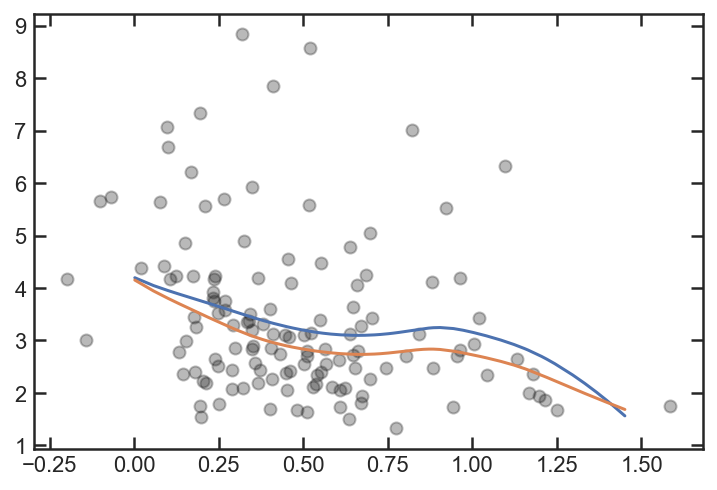

In [303]:
Amd,Amn,zmedian, zmean, zvar = Roll_bin_stat(np.log10(mdb.A.values), mdb.z_50.values,.4)
plt.scatter(np.log10(mdb.A.values), mdb.z_50.values, color='k', alpha = 0.3)
plt.plot(Amn,Smooth(Amn,zmean,0.1))
plt.plot(Amn,Smooth(Amn,zmedian,0.1))


In [66]:
GNSNR = pd.read_pickle('../dataframes/galaxy_frames/GN_cnd.pkl')
GSSNR = pd.read_pickle('../dataframes/galaxy_frames/GS_cnd.pkl')


In [75]:
GNSNR.query('id == {0}'.format(mdb.id[1])).SNR.values[0]


24.02991427941071

GND 15901 3.083858316793339 1.00198
GND 23490 2.3980201898891584 0.77511
GND 37180 2.4811912804180896 0.80581
GSD 44946 2.2620234429693205 1.03664
GSD 48631 2.841226656606362 1.16388


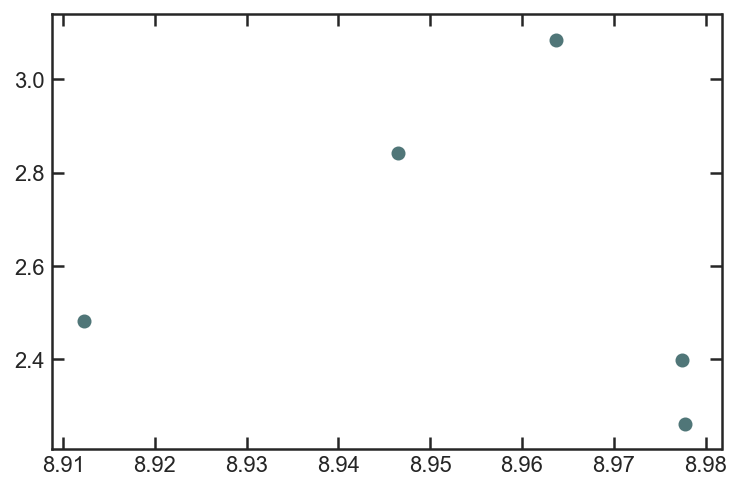

In [113]:
# plt.figure(figsize=[8,10])
# ax1 = plt.subplot(gs[1])
for i in mdb.index:
    if mdb.field[i][1] == 'S':
        try:
            if GSSNR.query('id == {0}'.format(mdb.id[i])).SNR.values[0] > 10 and np.log10(mdb.Sigma1[i]) < 9.0 and 1< mdb.z_50[i] < 6:
                plt.scatter(np.log10(mdb.Sigma1[i]), mdb.z_50[i], color = '#507678')
                print(mdb.field[i],mdb.id[i], mdb.z_50[i], mdb.zgrism[i])
        except:
            pass
    else:  
        try:
            if GNSNR.query('id == {0}'.format(mdb.id[i])).SNR.values[0] > 10 and np.log10(mdb.Sigma1[i]) < 9.0 and 1< mdb.z_50[i] < 6:
                plt.scatter(np.log10(mdb.Sigma1[i]), mdb.z_50[i], color = '#507678')
                
                print(mdb.field[i],mdb.id[i], mdb.z_50[i], mdb.zgrism[i])
                
        except:
            pass
        
# plt.xlim(10,9.0)
    

In [78]:
from spec_tools import Posterior_spec

GS_seg = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_seg.fits')[0].data
GN_seg = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_seg.fits')[0].data

GS_f125 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F125W_orig_sci.fits')[0].data
GN_f125 = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F125W_orig_sci.fits')[0].data

GS_f160 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_orig_sci.fits')[0].data
GN_f160 = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_orig_sci.fits')[0].data

def IMG_pull(field, galaxy, zspec):
    if field == 'GND':
        segmap = np.array(GN_seg)
        if zspec <= 1.5:
            filt = np.array(GN_f125)
        else:
            filt = np.array(GN_f160)
        
    else:
        segmap = np.array(GS_seg)
        if zspec <= 1.5:
            filt = np.array(GS_f125)
        else:
            filt = np.array(GS_f160)
            
    idx = np.argwhere(segmap == galaxy)

    ylist = np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)
    xlist = np.arange(min(idx.T[1]), max(idx.T[1]) + 1, 1)

    segimg = segmap[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    filtimg = np.array(filt[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])])
    filtimg[segimg != galaxy] = 0

    ycnt = ylist[np.argmax(np.sum(filtimg, axis=1))]
    xcnt = xlist[np.argmax(np.sum(filtimg.T, axis=1))]

    filtimg = filt[ycnt - 20: ycnt + 20, xcnt - 20: xcnt + 20]
    segmask = segimg[ycnt - 20: ycnt + 20, xcnt - 20: xcnt + 20]
#     filtimg[segmask != galaxy] = 0
    
    return filtimg

def rescale_img(img,zspec):
    yarc = 40*0.064; xarc = 40*0.064

    ykpc = yarc/cosmo.arcsec_per_kpc_proper(zspec).value
    xkpc = xarc/cosmo.arcsec_per_kpc_proper(zspec).value
    xnew = np.linspace(xkpc/2 - 8, xkpc/2 +8 ,40)
    ynew = np.linspace(ykpc/2 - 8, ykpc/2 +8,40)

    inimg = interp2d(np.arange(1,41,1)*xkpc/40,np.arange(1,41,1)*ykpc/40, img)

    return inimg(xnew,ynew)

In [79]:
zspec = 2
yarc = 40*0.06; xarc = 40*0.068

ykpc = yarc/cosmo.arcsec_per_kpc_proper(zspec).value
xkpc = xarc/cosmo.arcsec_per_kpc_proper(zspec).value
xnew = np.linspace(xkpc/2 - 8, xkpc/2 +8 ,40)
ynew = np.linspace(ykpc/2 - 8, ykpc/2 +8,40)

# inimg = interp2d(np.arange(1,41,1)*xkpc/40,np.arange(1,41,1)*ykpc/40, img)

In [72]:
ynew

array([ 2.29916678,  2.70942319,  3.1196796 ,  3.52993601,  3.94019242,
        4.35044883,  4.76070524,  5.17096166,  5.58121807,  5.99147448,
        6.40173089,  6.8119873 ,  7.22224371,  7.63250012,  8.04275653,
        8.45301294,  8.86326935,  9.27352576,  9.68378217, 10.09403858,
       10.50429499, 10.9145514 , 11.32480781, 11.73506422, 12.14532063,
       12.55557704, 12.96583345, 13.37608986, 13.78634627, 14.19660268,
       14.60685909, 15.0171155 , 15.42737191, 15.83762832, 16.24788473,
       16.65814114, 17.06839755, 17.47865396, 17.88891037, 18.29916678])

In [66]:
xkpc, ykpc

(21.002809142504752, 18.53189041985713)

In [45]:
img.shape

(40, 40)

In [80]:
galaxies = [46066,39170,41520,21156,44620,39631,45972,40862,23490]

for gal in galaxies:
    img = IMG_pull(mdb.query('id == {}'.format(gal)).field.values[0],gal,mdb.query('id == {}'.format(gal)).zgrism.values[0])
    rsimg = rescale_img(img,mdb.query('id == {}'.format(gal)).zgrism.values[0])
    np.save('../data/imgfiles/{0}_{1}_img'.format(mdb.query('id == {}'.format(gal)).field.values[0],gal),img)
    np.save('../data/imgfiles/{0}_{1}_rsimg'.format(mdb.query('id == {}'.format(gal)).field.values[0],gal),rsimg)    

In [119]:
def PLOT(field, galaxy, savefig = False):
    grow = morph_db.query('id == {0}'.format(galaxy))

    Gs = Gen_spec(field, galaxy, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
    Flam = Posterior_spec(field, galaxy)
    
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field, galaxy))
    bp1 = x[px == max(px)][0]
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field, galaxy))
    rp1 = x[px == max(px)][0]
    
    Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

    sfh = Rescale_sfh(field, galaxy)

    gs = gridspec.GridSpec(1,2,width_ratios=[1,3], hspace=0.3, wspace = 0.2)   
    plt.figure(figsize=[12,3])
    ###############plot tab##################
    plt.subplot(gs[1])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
    else:
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]
        
    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
    else:
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='o', markersize=10, markerfacecolor='#B5677D', zorder = 1,
                 markeredgecolor = '#685877',markeredgewidth = 1)

    plt.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 1, label = 'Model', zorder=5)
    plt.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 1)
    plt.xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))

    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.title(galaxy, fontsize=15)
    plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=15)
    plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)

    #################plot image###################
    rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(field, galaxy))
    
    plt.subplot(gs[0])
    plt.imshow(-np.arcsinh(rsimg))    
    plt.xticks([])
    plt.yticks([])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


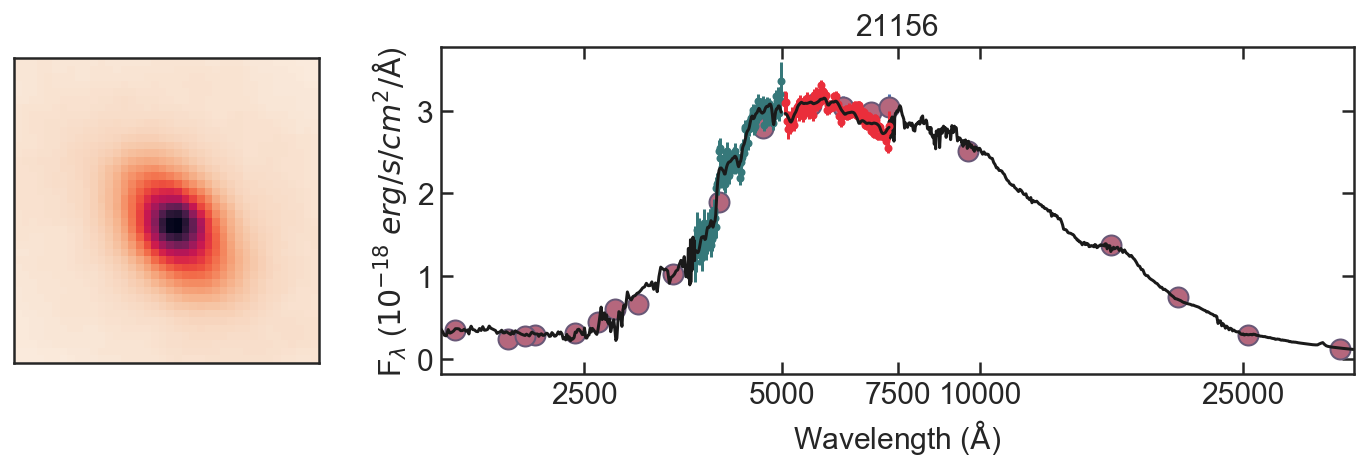

In [120]:
PLOT('GND', 21156)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/minico

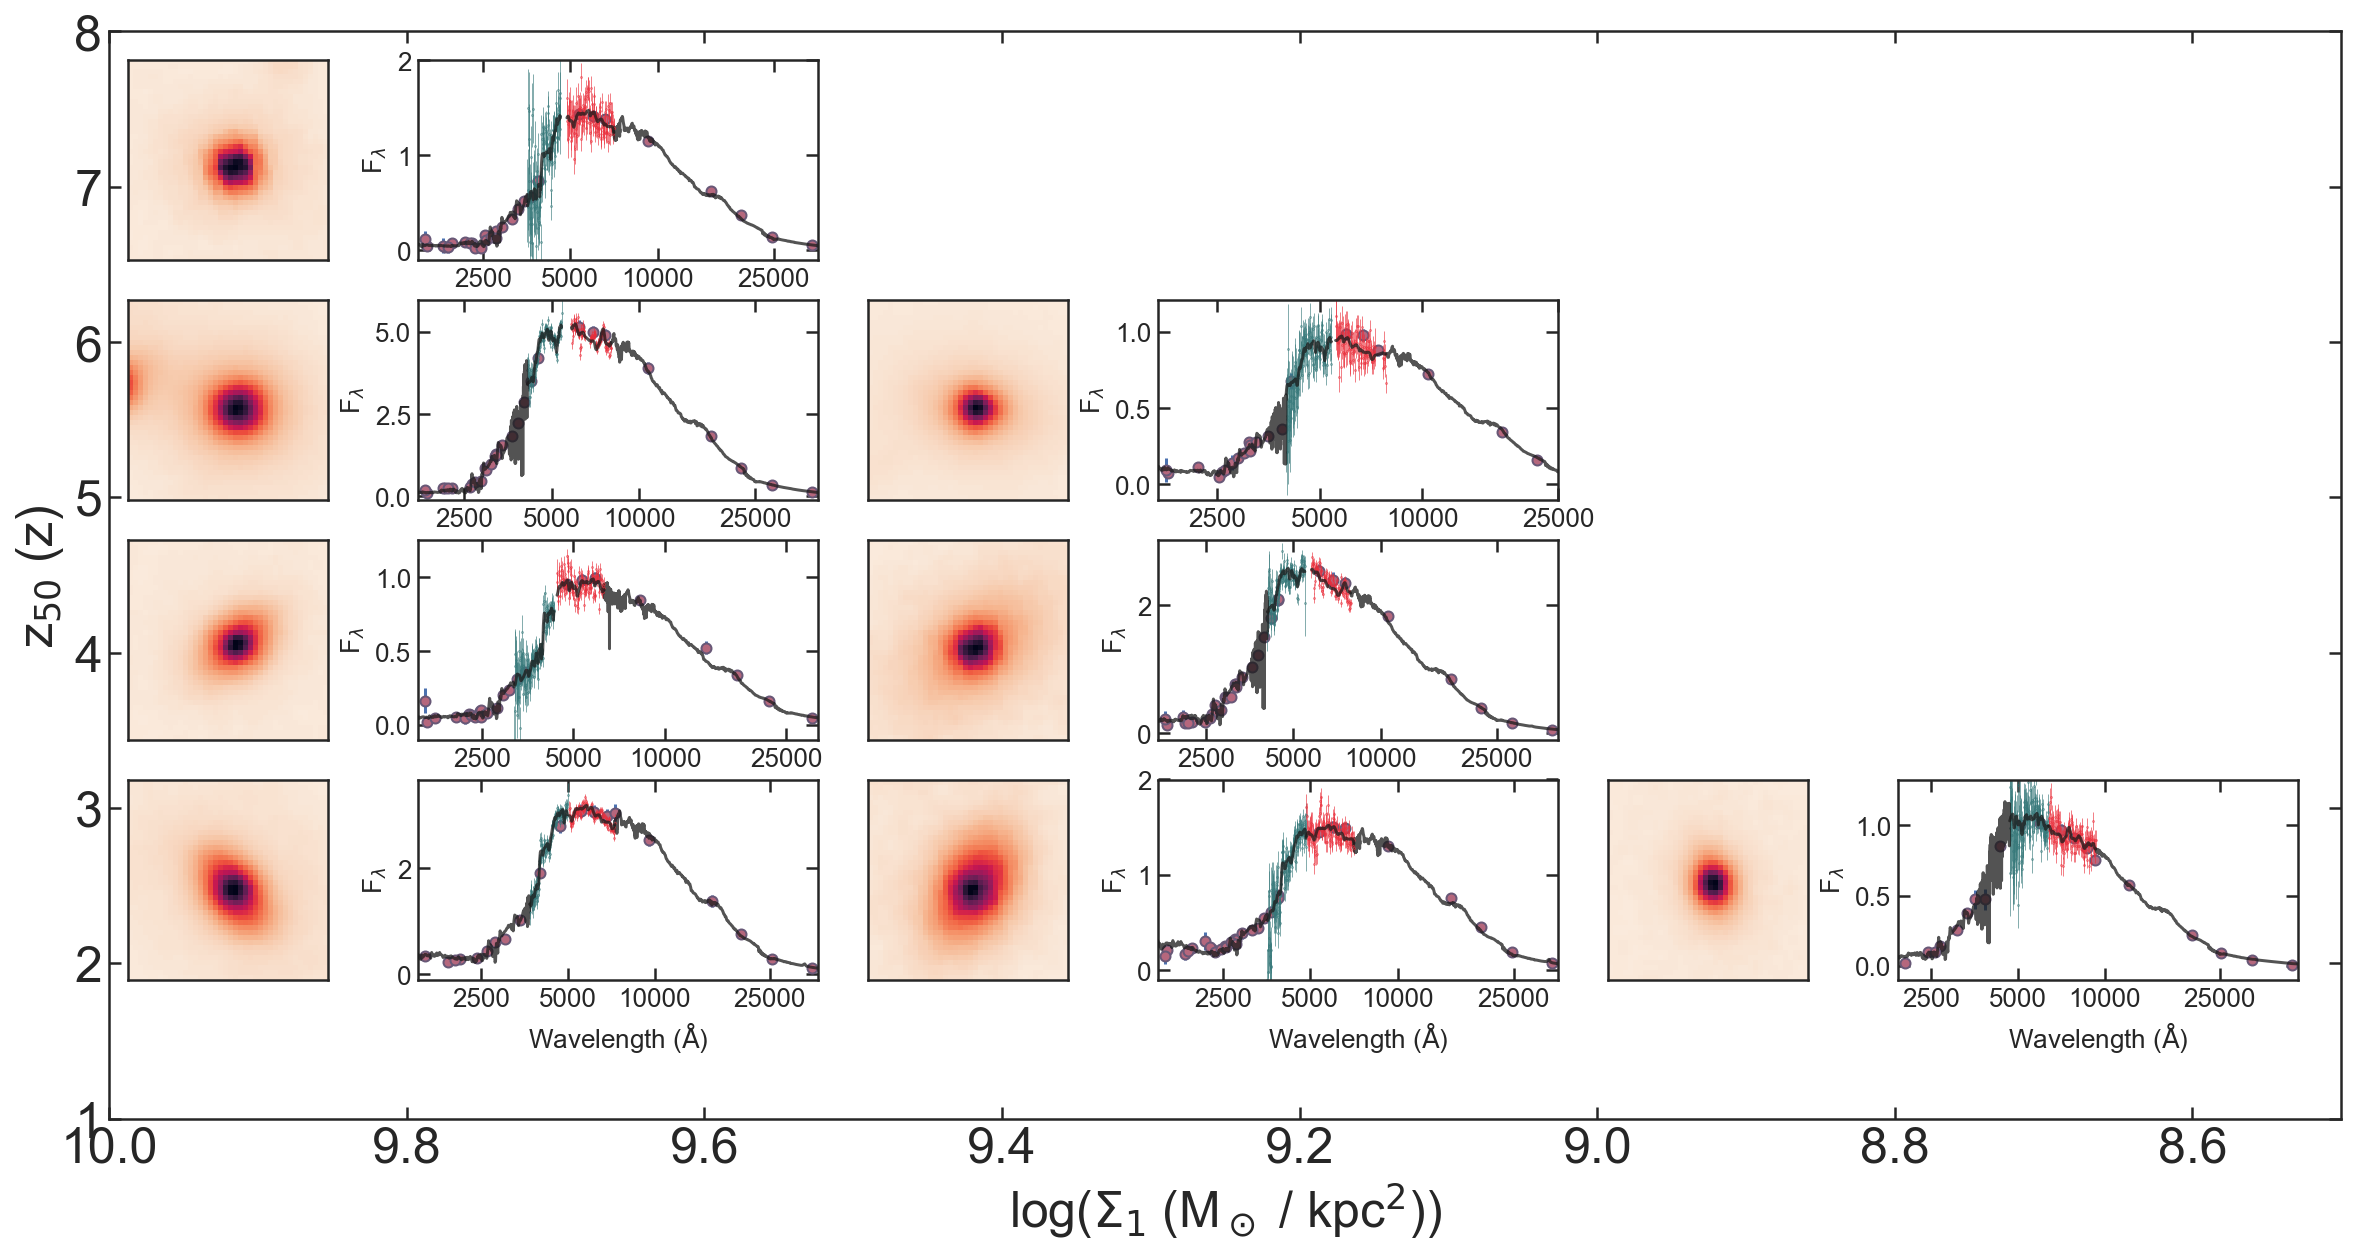

In [266]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=[20,10])
ax1 = plt.subplot()
# ax1.axvline(9.5)
# ax1.axvline(9.0)


# sea.scatterplot(np.log10(mdb.Sigma1), mdb.z_50, color = '#C4253C', 
#                 size=mdb.zgrism,sizes=(60, 200),legend=False, ax=ax1, alpha = 0.1)
plt.ylim(1,8)
plt.xlim(10,8.5)

plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=25)
plt.ylabel('z$_{50}$ (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)


xlocs = [390,390,390,390,1130,1130,1130,1870]
ylocs = [1050,810,570,330,810,570,330,330]
# galaxies = [46066,39170,41520,21156,44620,3963140862,23490]
galaxies = [46066,39170,41520,21156,44620,45972,40862,23490]

field = ['GSD','GSD','GSD','GND','GSD','GSD','GSD','GND']
for i in range(len(xlocs)):
    grow = morph_db.query('id == {0}'.format(galaxies[i]))

    rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(field[i], galaxies[i]))

    ax1_inset = inset_axes(ax1, width="100%", height="100%", bbox_to_anchor=[xlocs[i], ylocs[i], 200, 200])
    ax1_inset.imshow(-np.arcsinh(rsimg))#, vmin = -1, vmax = 0.1)
    ax1_inset.set_xticks([])
    ax1_inset.set_yticks([])
    
    ax2_inset = inset_axes(ax1, width="100%", height="100%", bbox_to_anchor=[xlocs[i] + 290, ylocs[i], 400, 200])

    Gs = Gen_spec(field[i], galaxies[i], grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
    Flam = Posterior_spec(field[i], galaxies[i])

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field[i], galaxies[i]))
    bp1 = x[px == max(px)][0]
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field[i], galaxies[i]))
    rp1 = x[px == max(px)][0]

    Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

    sfh = Rescale_sfh(field[i], galaxies[i])

    ###############plot tab##################

    if Gs.g102:
        ax2_inset.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.3)
        ax2_inset.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
    else:
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]

    if Gs.g141:
        ax2_inset.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.3)
        ax2_inset.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
    else:
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

    ax2_inset.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='o', markersize=5, markerfacecolor='#B5677D', zorder = 1,
                 markeredgecolor = '#685877',markeredgewidth = 1)

    ax2_inset.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 0.75, label = 'Model', zorder=5)
    ax2_inset.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 0.75)
    ax2_inset.set_xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
    ax2_inset.set_ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

    ax2_inset.set_xticks(np.log10([2500,5000,10000,25000]))
    ax2_inset.set_xticklabels(np.array([2500,5000,10000,25000]))
#     ax2_inset.set_title(galaxies[i], fontsize=13)
    ax2_inset.set_xlabel(r'Wavelength ($\rm \AA$)', fontsize=13)
    ax2_inset.set_ylabel(r'F$_\lambda$', fontsize=13)
    ax2_inset.tick_params(axis='both', which='major', labelsize=13)
    
plt.savefig('../plots/z_50_spec.pdf', bbox_inches = 'tight')

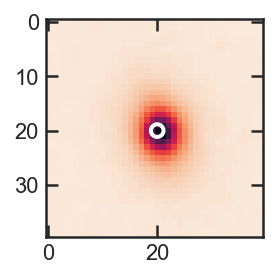

In [274]:
plt.figure(figsize=[4,2])
ax = plt.subplot()
grow = morph_db.query('id == {0}'.format(galaxies[i]))

rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(field[i], galaxies[i]))

ax.imshow(-np.arcsinh(rsimg))#, vmin = -1, vmax = 0.1)
circle1=plt.Circle((20,20),radius=grow.Re.values[0] * 20/16,ec='w',fc='none', linewidth=2)
ax.add_artist(circle1)

In [282]:
grow.Re.values[0] * 20/16, grow.n_f160, np.log10(grow.Sigma1)

(1.1624316193548843, 17    3.0057
 Name: n_f160, dtype: float64, 17    8.977452
 Name: Sigma1, dtype: float64)

In [ ]:
field = 'GND'
galaxy = 21156

grow = morph_db.query('id == {0}'.format(galaxy))

Gs = Gen_spec(field, galaxy, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
Flam = Posterior_spec(field, galaxy)

x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field, galaxy))
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field, galaxy))
rp1 = x[px == max(px)][0]

Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

sfh = Rescale_sfh(field, galaxy)

gs = gridspec.GridSpec(1,2,width_ratios=[1,3], hspace=0.3, wspace = 0.2)   
    ###############plot tab##################
axin = ax1_inset.subplot(gs[1])

if Gs.g102:
    axin.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
            linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)
    axin.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)
    IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
else:
    IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]

if Gs.g141:
    axin.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
            linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)
    axin.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)
    IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
else:
    IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

axin.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=10, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)

axin.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 1, label = 'Model', zorder=5)
axin.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 1)
axin.xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))

axin.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
axin.title(galaxy, fontsize=15)
axin.xlabel(r'Wavelength ($\rm \AA$)', fontsize=15)
axin.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=15)
axin.tick_params(axis='both', which='major', labelsize=15)

#################plot image###################
rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(field, galaxy))

axin2 = ax1_inset.subplot(gs[0])
axin2.imshow(-np.arcsinh(rsimg))    
axin2.xticks([])
axin2.yticks([])

In [288]:
np.argwhere(rsimg == rsimg.max())[0]

array([20, 21])

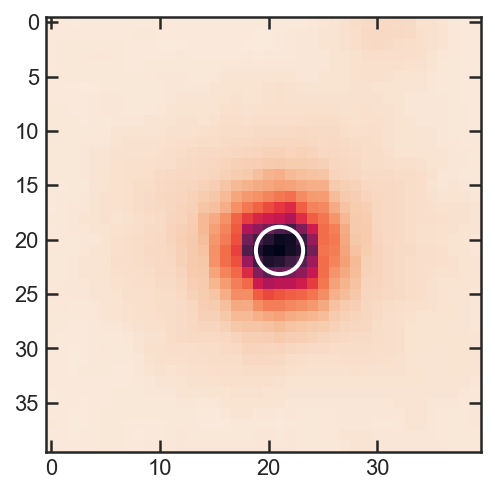

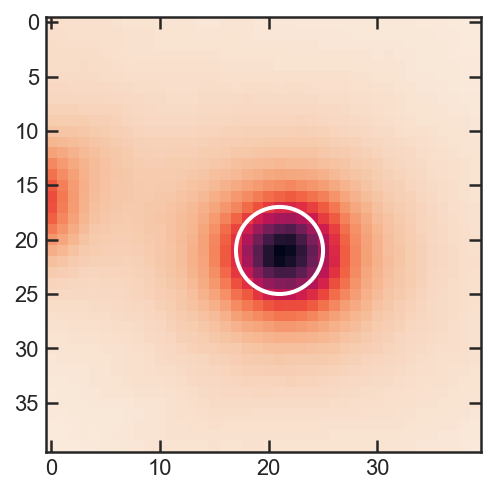

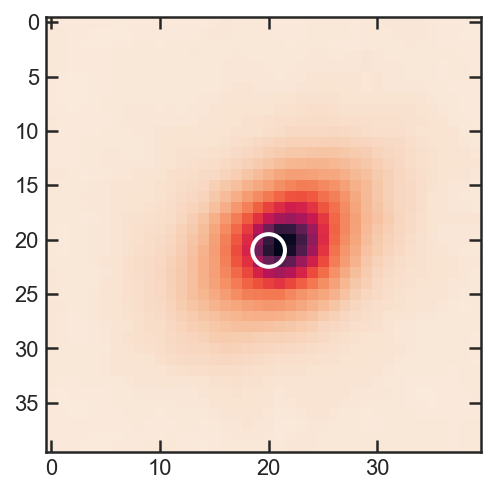

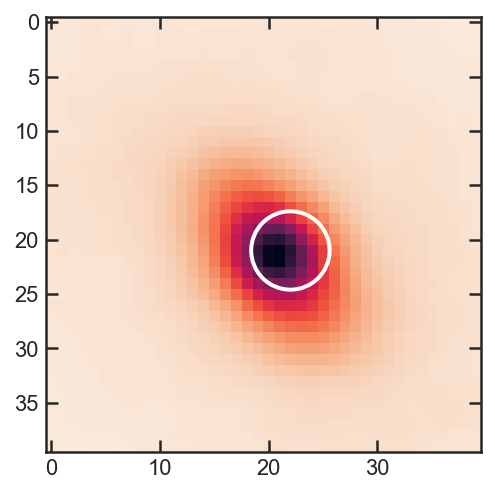

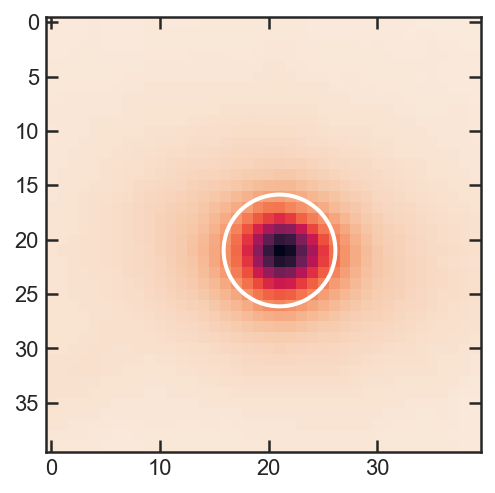

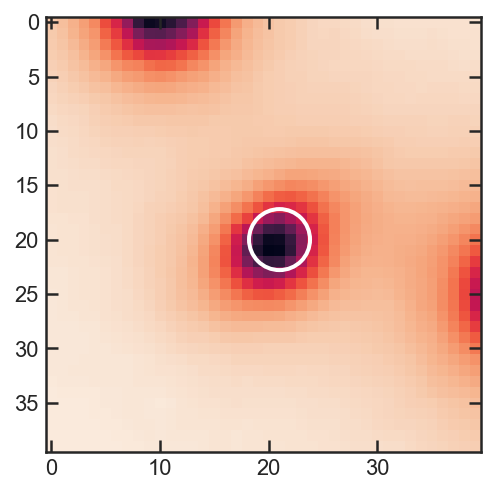

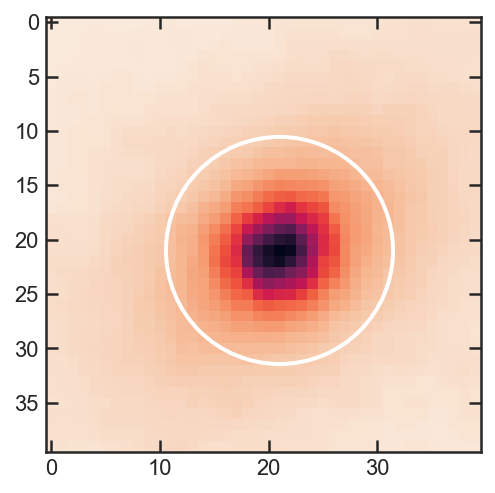

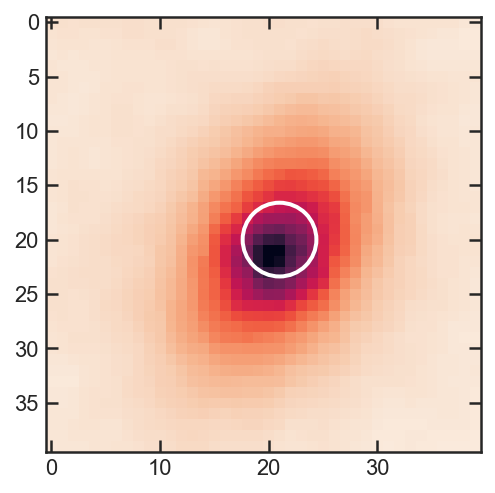

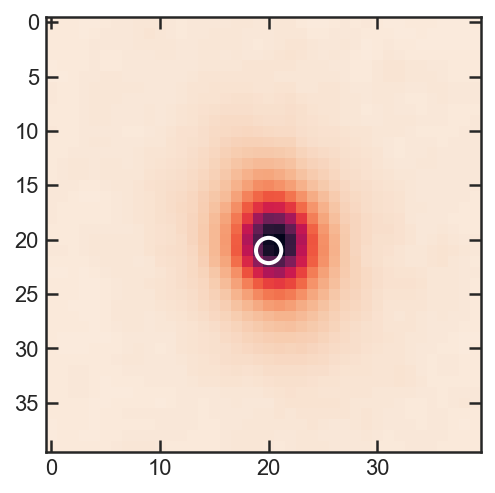

In [289]:

galaxies = [46066,39170,41520,21156,44620,39631,45972,40862,23490]

for gal in galaxies:
    rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(mdb.query('id == {}'.format(gal)).field.values[0],gal))
    grow = morph_db.query('id == {0}'.format(gal))

    plt.figure()
    ax = plt.subplot()
    ax.imshow(-np.arcsinh(rsimg))#, vmin = -1, vmax = 0.1)
    circle1=plt.Circle(np.argwhere(rsimg == rsimg.max())[0],radius=grow.Re.values[0] * 20/16,ec='w',fc='none', linewidth=2)
    ax.add_artist(circle1)
    



In [292]:
mdb.query('id == 45972').n_f160

69    5.9565
Name: n_f160, dtype: float64

In [151]:
zllim = [0.8, 0.94, 1.02, 1.2, 1.55]
zhlim = [0.94, 1.02, 1.2, 1.55, 2.5]


for i in range(len(colors)):
    vals = []
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            vals.append(mdb.z_50[ii])
    print(len(vals))

24
29
32
23
27


24
29
32
23
27


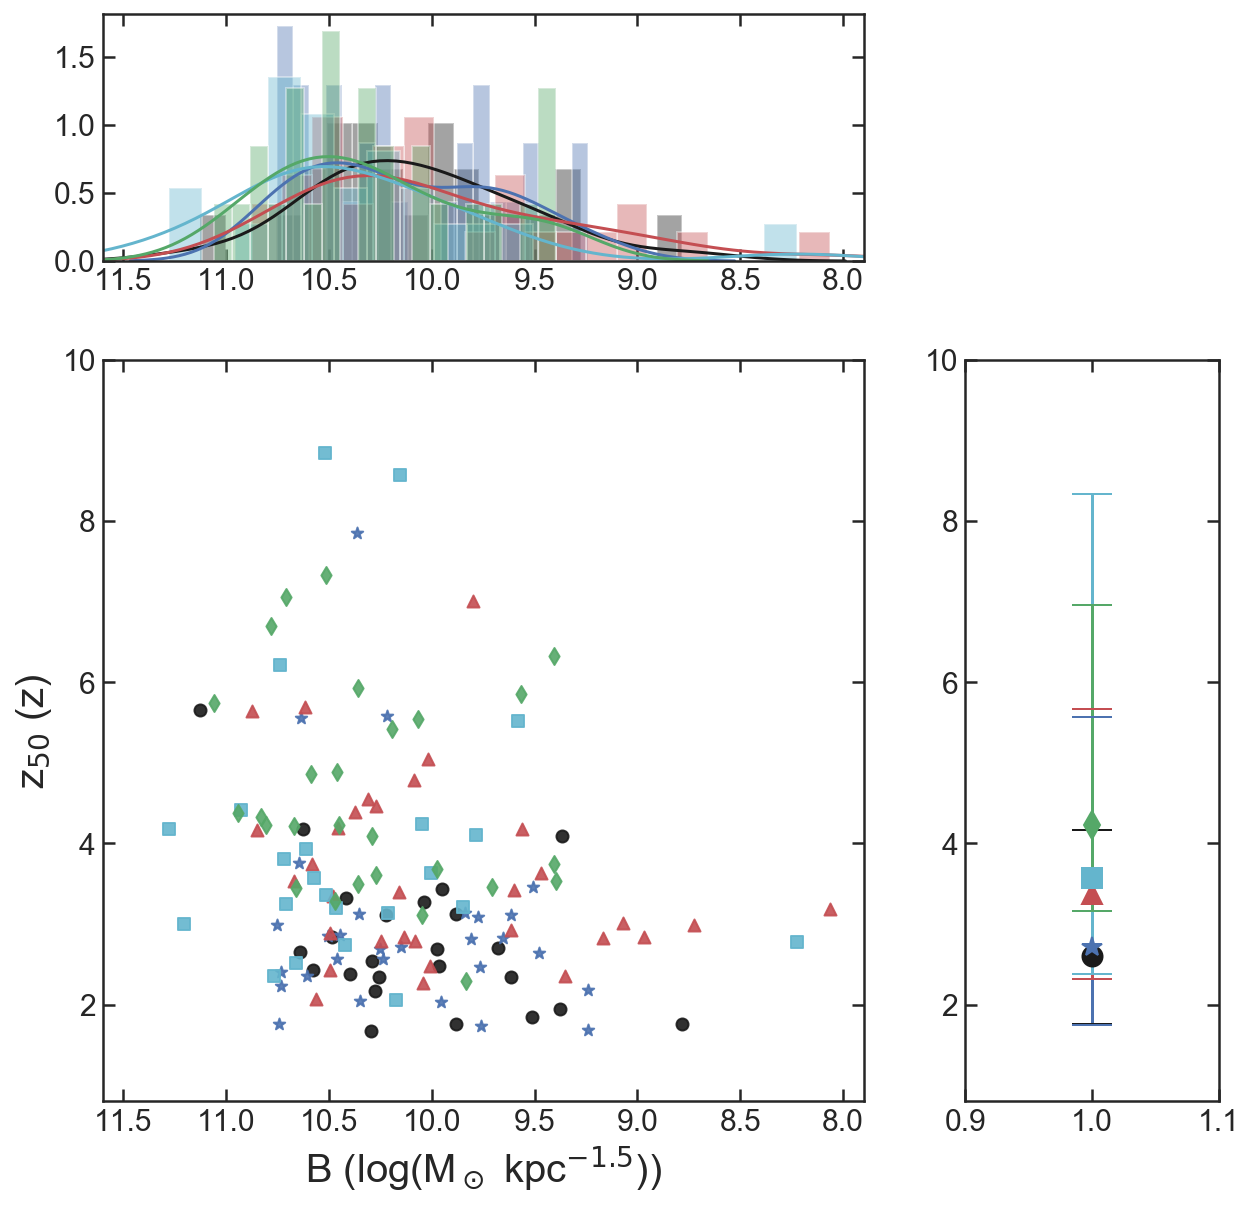

In [152]:
gs = gridspec.GridSpec(2,2,height_ratios=[1,3],width_ratios=[3,1])

colors = ['k','b','r','c','g']
markers = ['o','*','^','s','d']
zllim = [0.8, 0.94, 1.02, 1.2, 1.55]
zhlim = [0.94, 1.02, 1.2, 1.55, 2.5]


plt.figure(figsize=[10,10])
ax1 = plt.subplot(gs[1,0])

for i in range(len(colors)):
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            plt.scatter(mdb.B[ii], mdb.z_50[ii], color = colors[i], marker=markers[i],
                            alpha = 0.9)

plt.ylim(0.8,10)
plt.xlim(11.6,7.9)

plt.xlabel('B (log(M$_\odot$ kpc$^{-1.5}$))', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

ax2 = plt.subplot(gs[0,0])

for i in range(len(colors)):
    vals = []
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            vals.append(mdb.B[ii])
    sea.distplot(vals, color = colors[i], kde = True, bins=19, ax = ax2)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(11.6,7.9)


ax3 = plt.subplot(gs[1,1])
for i in range(len(colors)):
    vals = []
    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            vals.append(mdb.z_50[ii])

    plt.errorbar(1, np.percentile(vals,50), 
                 yerr=[[np.percentile(vals,50) - np.percentile(vals,5)],
                       [np.percentile(vals,95) - np.percentile(vals,50)]],
                markersize = 10, marker = markers[i], capsize=10, color = colors[i])
    print(len(vals))
plt.ylim(0.8,10)
ax3.set_xlim(0.9,1.1)
plt.ylim(0.8,10)
zllim = [0.5,1.0,1.3,1.6,2.0]
plt.tick_params(axis='both', which='major', labelsize=15)

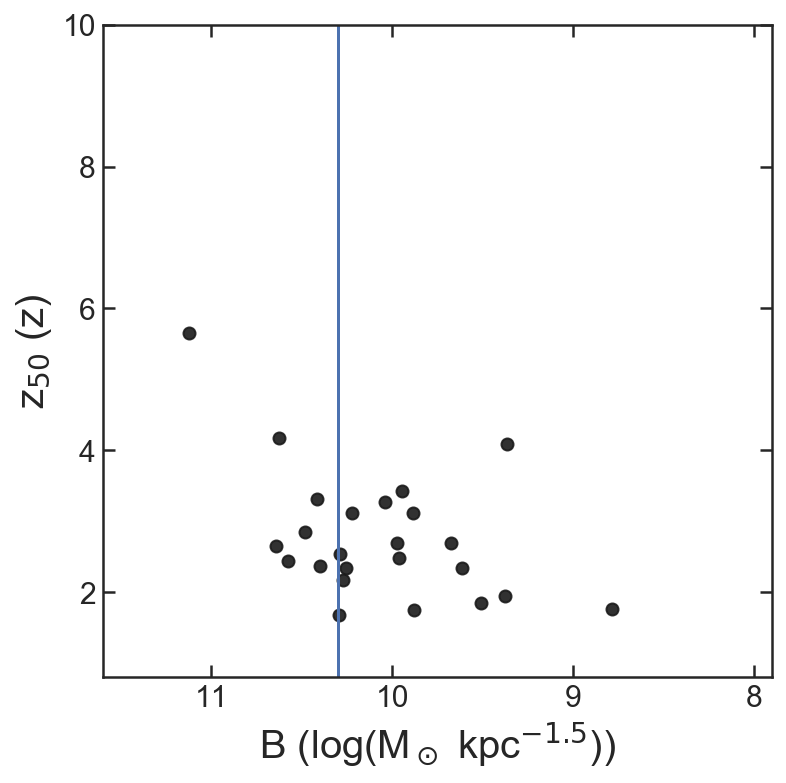

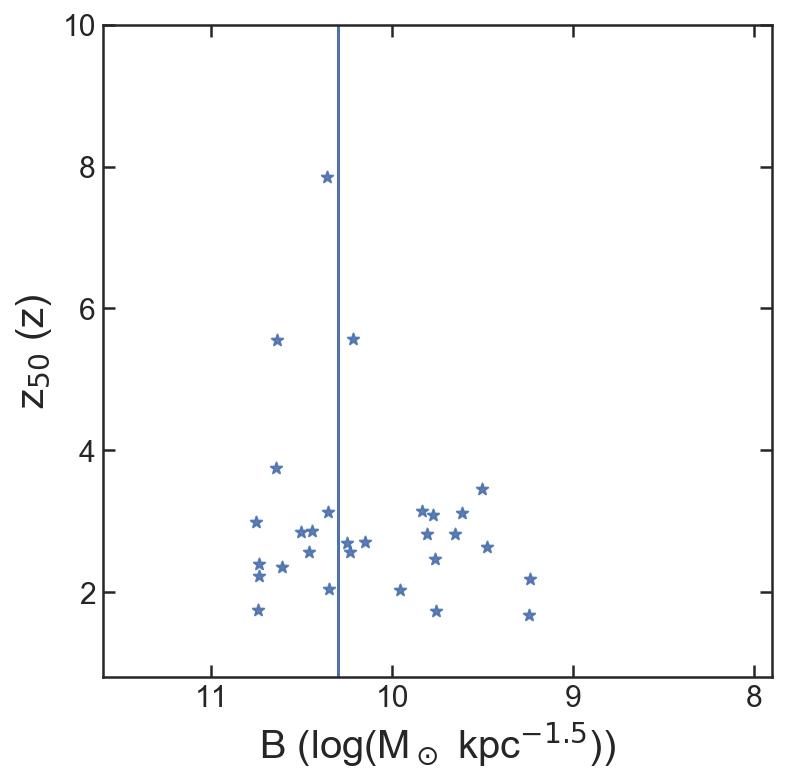

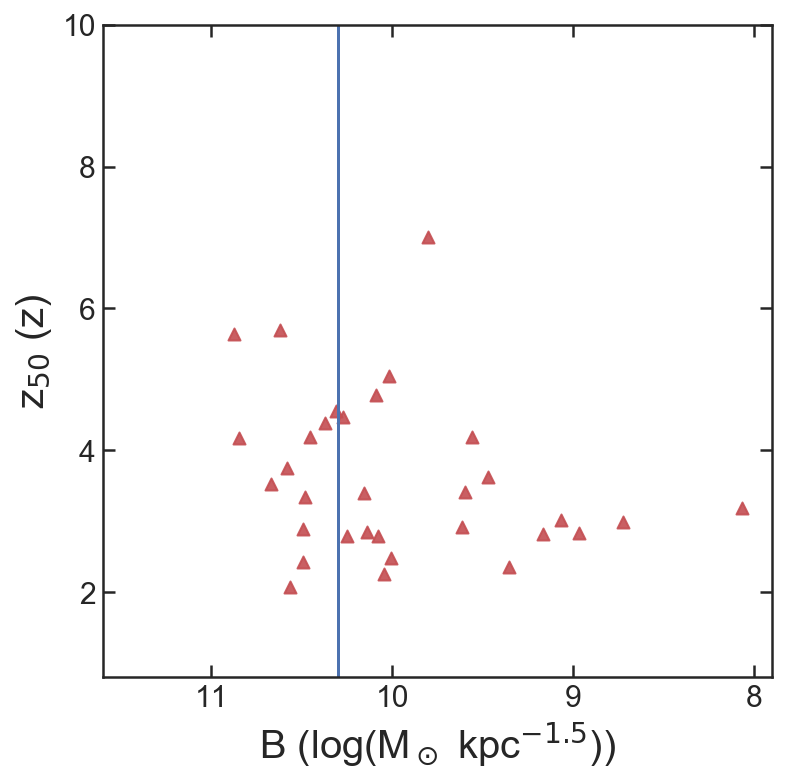

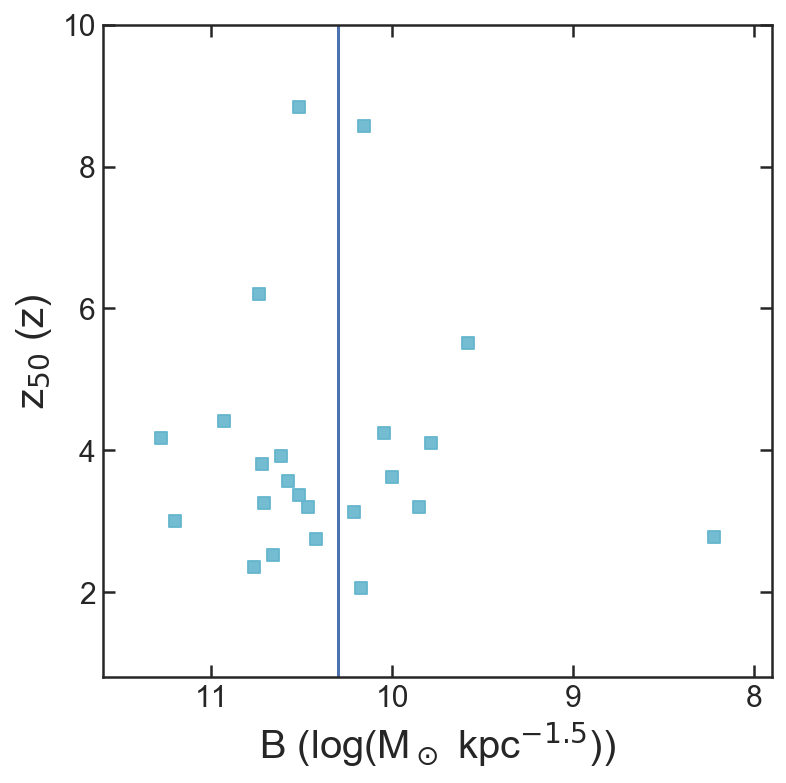

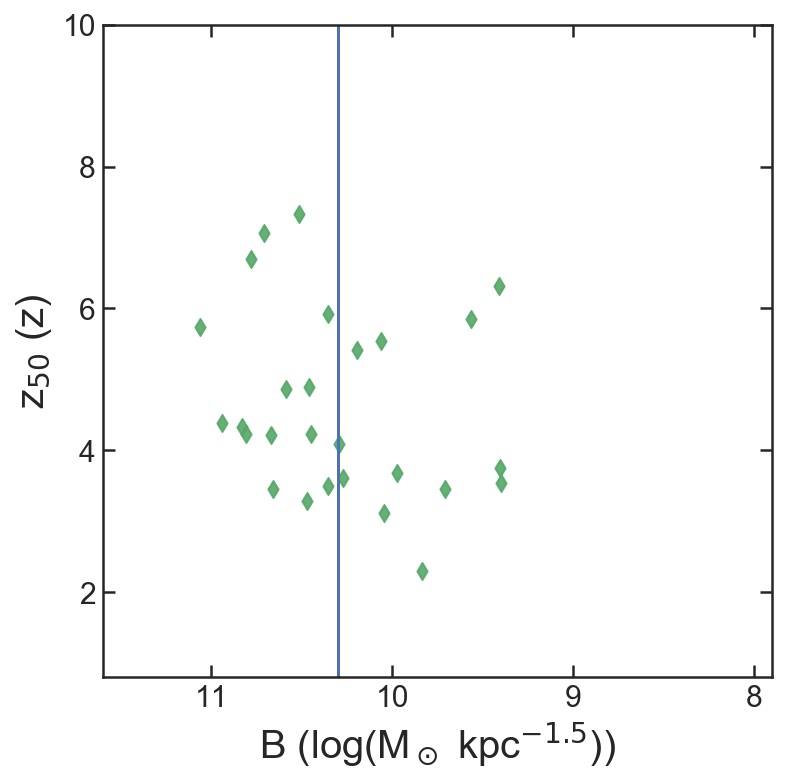

In [154]:
colors = ['k','b','r','c','g']
markers = ['o','*','^','s','d']
zllim = [0.8, 0.94, 1.02, 1.2, 1.55]
zhlim = [0.94, 1.02, 1.2, 1.55, 2.5]

for i in range(len(colors)):
    plt.figure(figsize=[6,6])

    for ii in mdb.index:
        if zllim[i] <= mdb.zgrism[ii] <zhlim[i]:
            plt.scatter(mdb.B[ii], mdb.z_50[ii], color = colors[i], marker=markers[i],
                            alpha = 0.9)
    plt.axvline(10.3)   
    plt.ylim(0.8,10)
    plt.xlim(11.6,7.9)

    plt.xlabel('B (log(M$_\odot$ kpc$^{-1.5}$))', fontsize=20)
    plt.ylabel('z$_{50}$ (z)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

(0, 9)

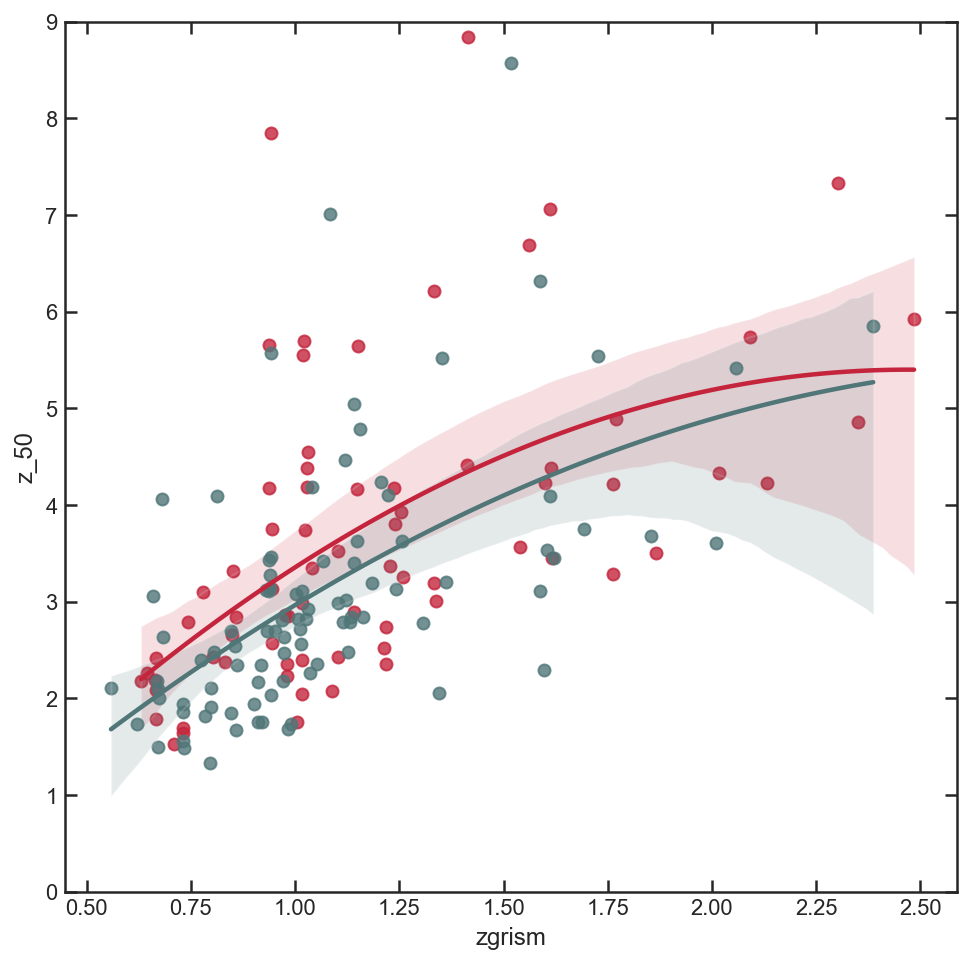

In [199]:
plt.figure(figsize=[8,8])
ax = plt.subplot()
sea.regplot(Cmdb.zgrism, Cmdb.z_50, color = '#C4253C',truncate = True, order = 2)
sea.regplot(Emdb.zgrism, Emdb.z_50, color = '#507678',truncate = True, order = 2)
ax.set_ylim(0,9)

(0, 6)

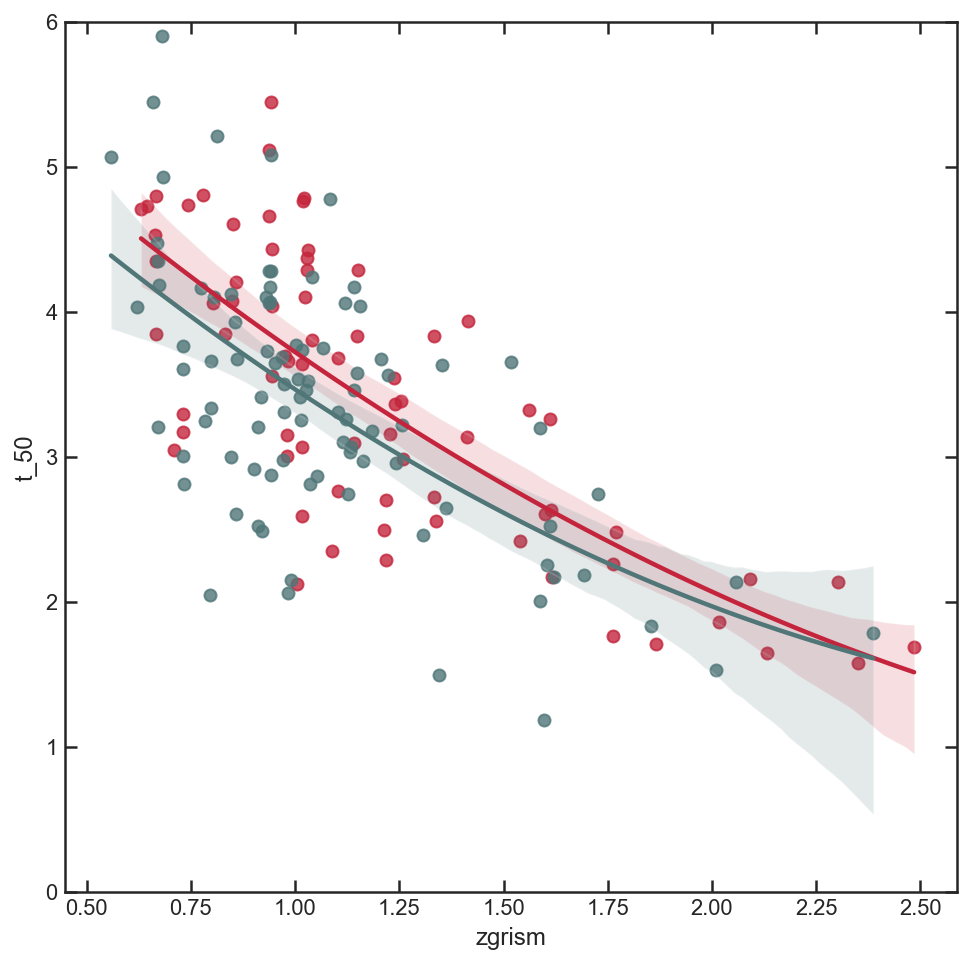

In [183]:
plt.figure(figsize=[8,8])
ax = plt.subplot()
sea.regplot(Cmdb.zgrism, Cmdb.t_50,order=2, color = '#C4253C',truncate=True)
sea.regplot(Emdb.zgrism, Emdb.t_50,order=2, color = '#507678',truncate=True)
ax.set_ylim(0,6)

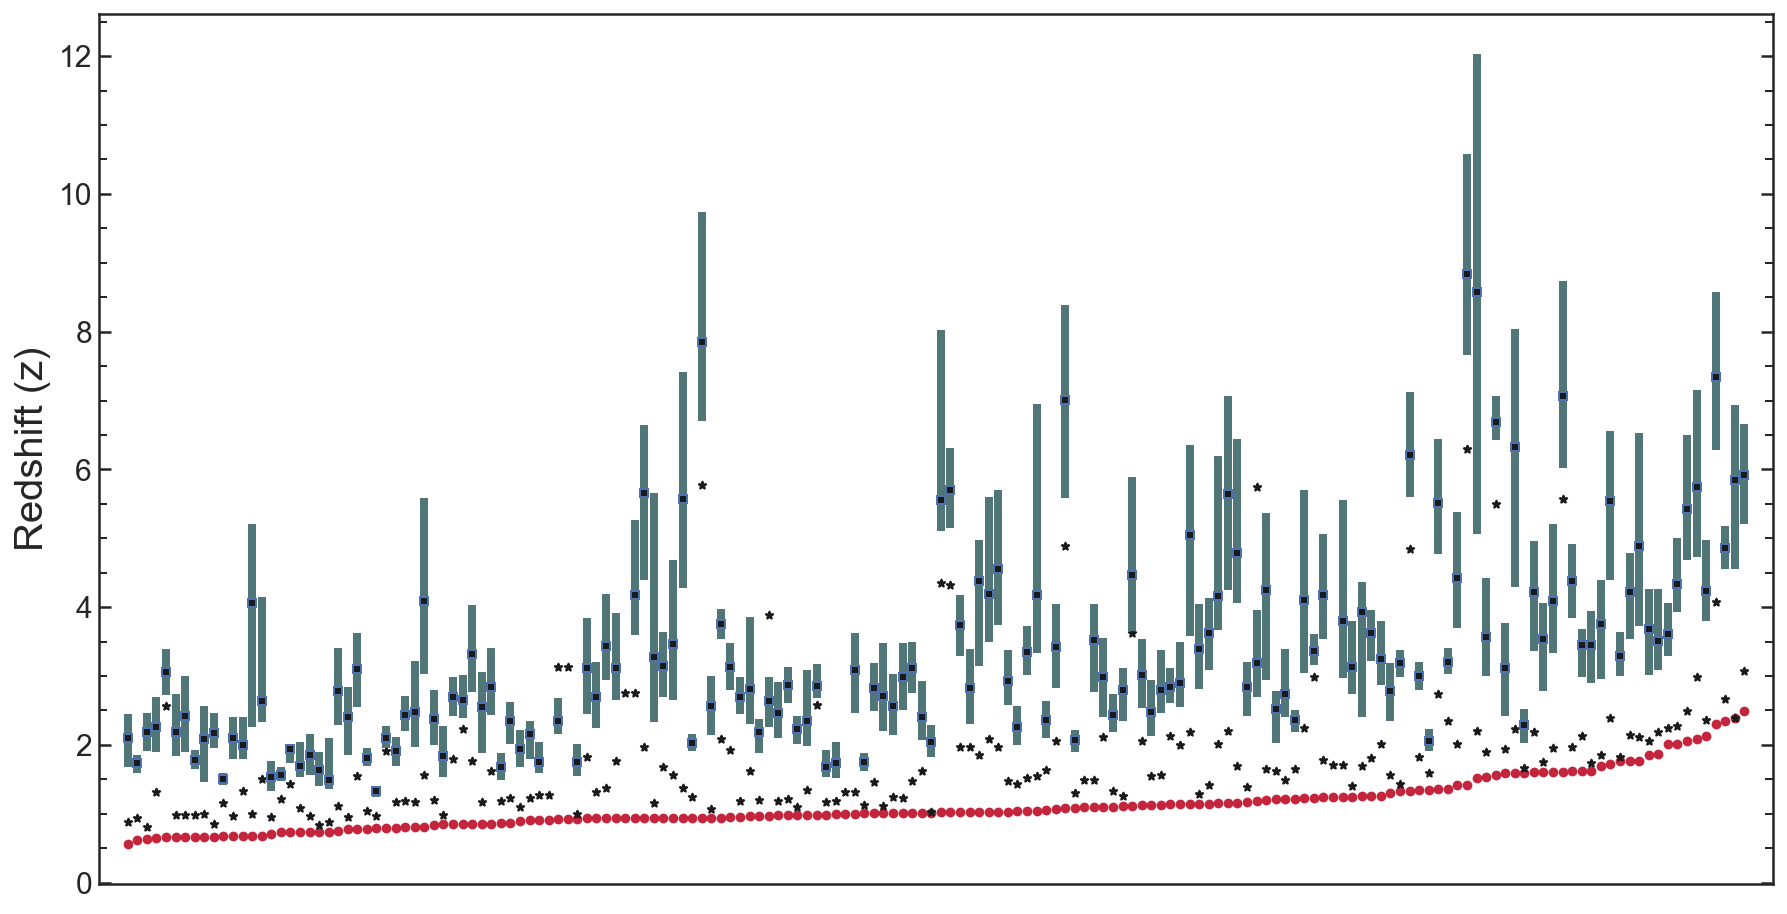

In [10]:
idx = 0
plt.figure(figsize=[15,8])
ax = plt.subplot()
for i in mdb.sort_values('zgrism').index:
    for ii in range(len(mdb.z_50_hci[i])//2):
#         if mdb.B[i] > 10.3:
        mr = 'o'
        cr = '#C4253C'
#         else:
#         mr = 'o'
#         cr = '#507678'
                
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            plt.errorbar([idx],mdb.z_50[i], yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], 
                        [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]],marker = 's', mfc= 'k', elinewidth = 4, ecolor = '#507678', markersize=4)
                
        plt.scatter([idx],mdb.zgrism[i], marker = mr, color = cr, s=15)
        plt.scatter([idx],mdb.z_q[i], marker = '*', color = 'k', s=15)
    
    
    
        idx += 1 
plt.xlim(-3,172)
plt.xticks([])

plt.ylabel('Redshift (z)', fontsize=20)
# plt.legend(fontsize =13, frameon = True, loc = 1)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../plots/redshift_dist.png', bbox_inches = 'tight')

(0, 12)

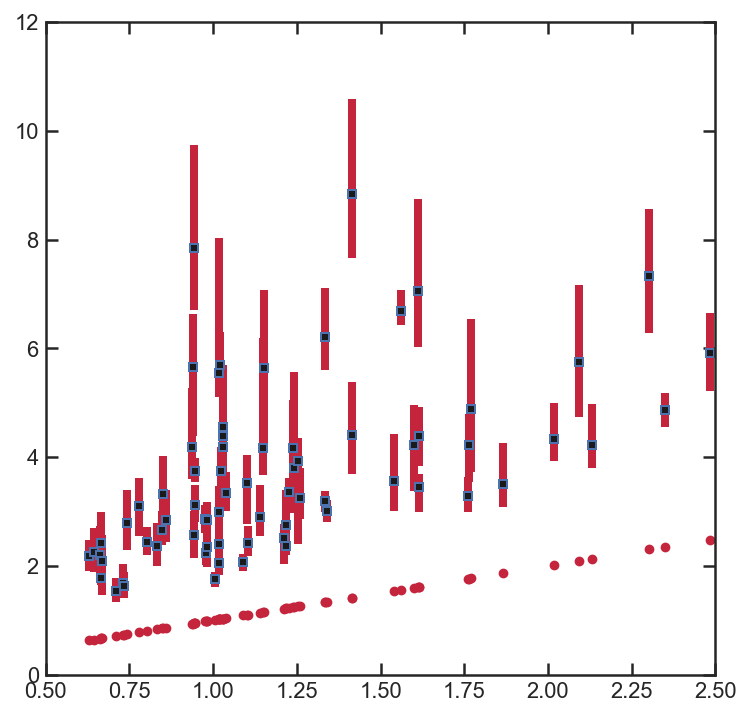

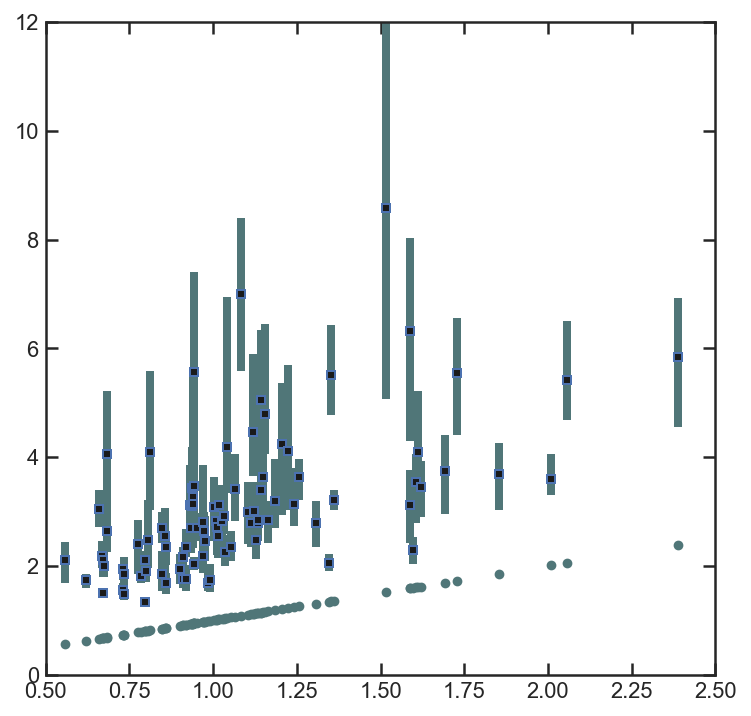

In [263]:
plt.figure(figsize=[6,6])
ax = plt.subplot()
for i in mdb.sort_values('zgrism').index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        mr = 'o'
        cr = '#C4253C'
                
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1] and mdb.B[i] > 10.3:
            plt.errorbar(mdb.zgrism[i],mdb.z_50[i], yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], 
                        [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]],marker = 's', mfc= 'k', elinewidth = 4, ecolor = cr, markersize=4)
                
            plt.scatter(mdb.zgrism[i],mdb.zgrism[i], marker = mr, color = cr, s=15)

plt.xlim(0.5,2.5)
plt.ylim(0,12)

plt.figure(figsize=[6,6])
ax = plt.subplot()
for i in mdb.sort_values('zgrism').index:
    for ii in range(len(mdb.z_50_hci[i])//2):

        mr = 'o'
        cr = '#507678'
                
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1] and mdb.B[i] < 10.3 :
            plt.errorbar(mdb.zgrism[i],mdb.z_50[i], yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], 
                        [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]],marker = 's', mfc= 'k', elinewidth = 4, ecolor = cr, markersize=4)
                
            plt.scatter(mdb.zgrism[i],mdb.zgrism[i], marker = mr, color = cr, s=15)
plt.xlim(0.5,2.5)
plt.ylim(0,12)

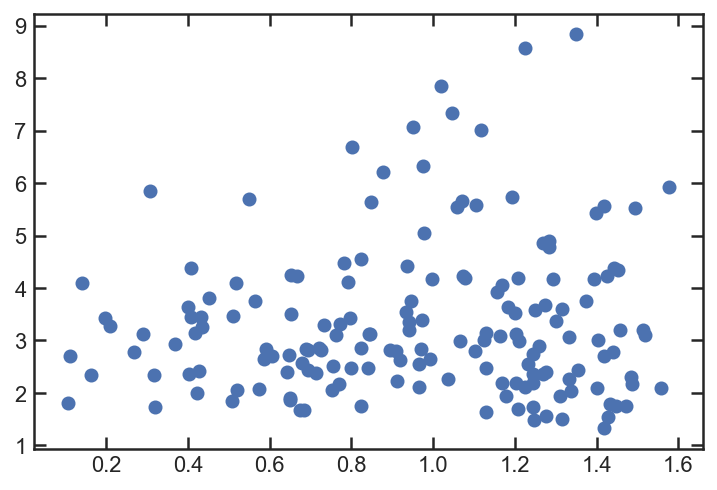

In [222]:
plt.scatter(mdb.Z, mdb.z_50)

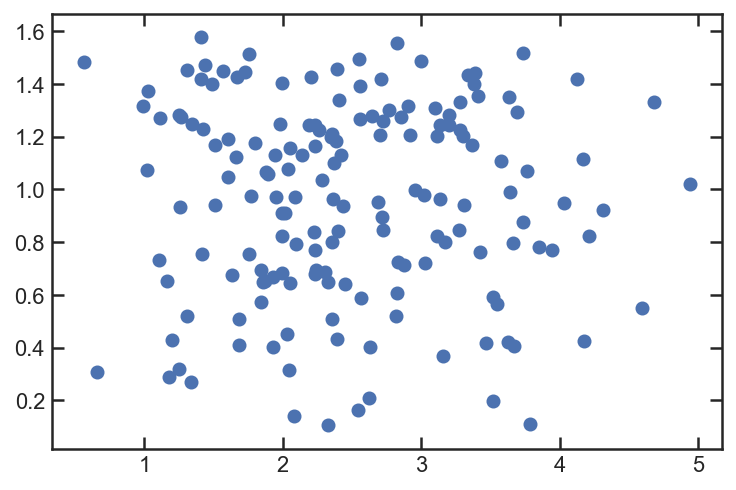

In [229]:
plt.scatter(mdb.lwa, mdb.Z)

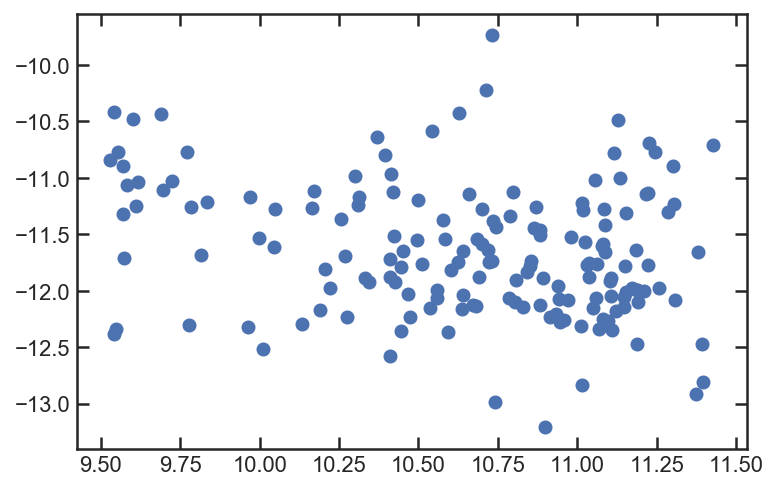

In [237]:
plt.scatter(mdb.lmass, mdb.log_ssfr)

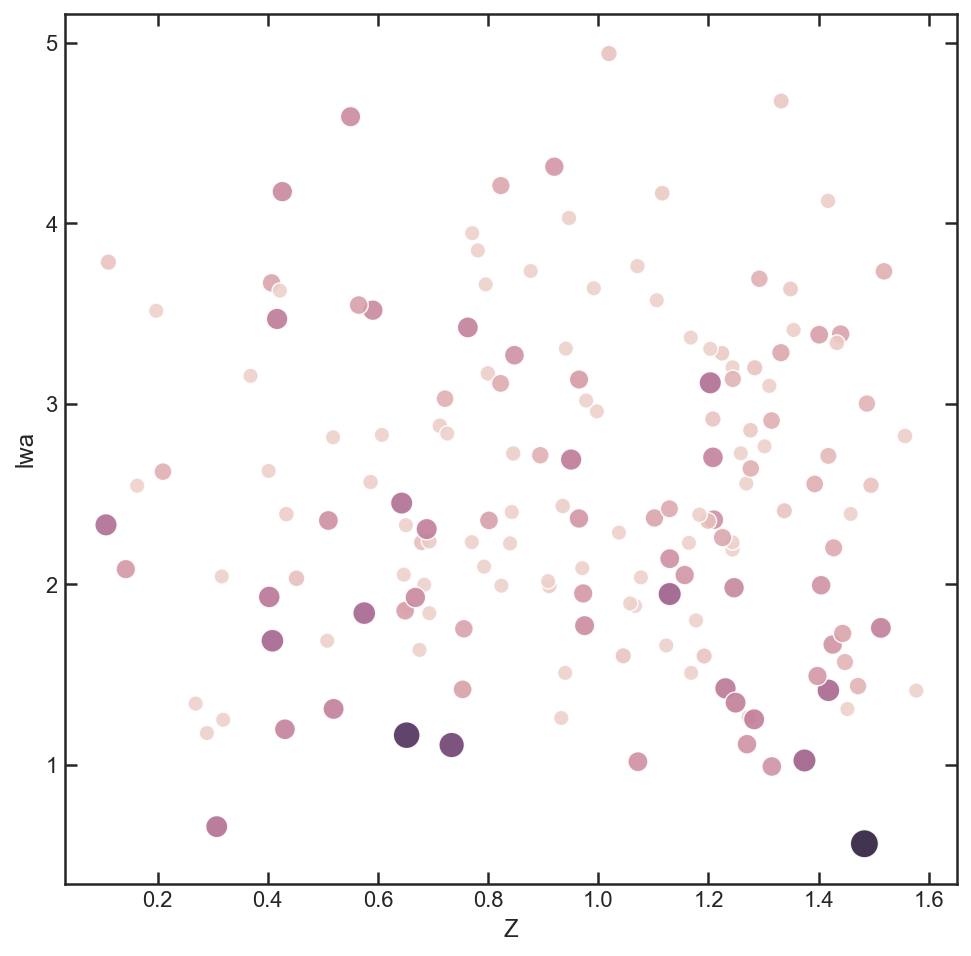

In [230]:
plt.figure(figsize=[8,8])
ax1 = plt.subplot()

sea.scatterplot(mdb.Z, mdb.lwa, color = '#507678',
                size=mdb.Av, hue=mdb.Av,sizes=(60, 200),legend=False, ax=ax1, alpha = 0.9)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0, 8)

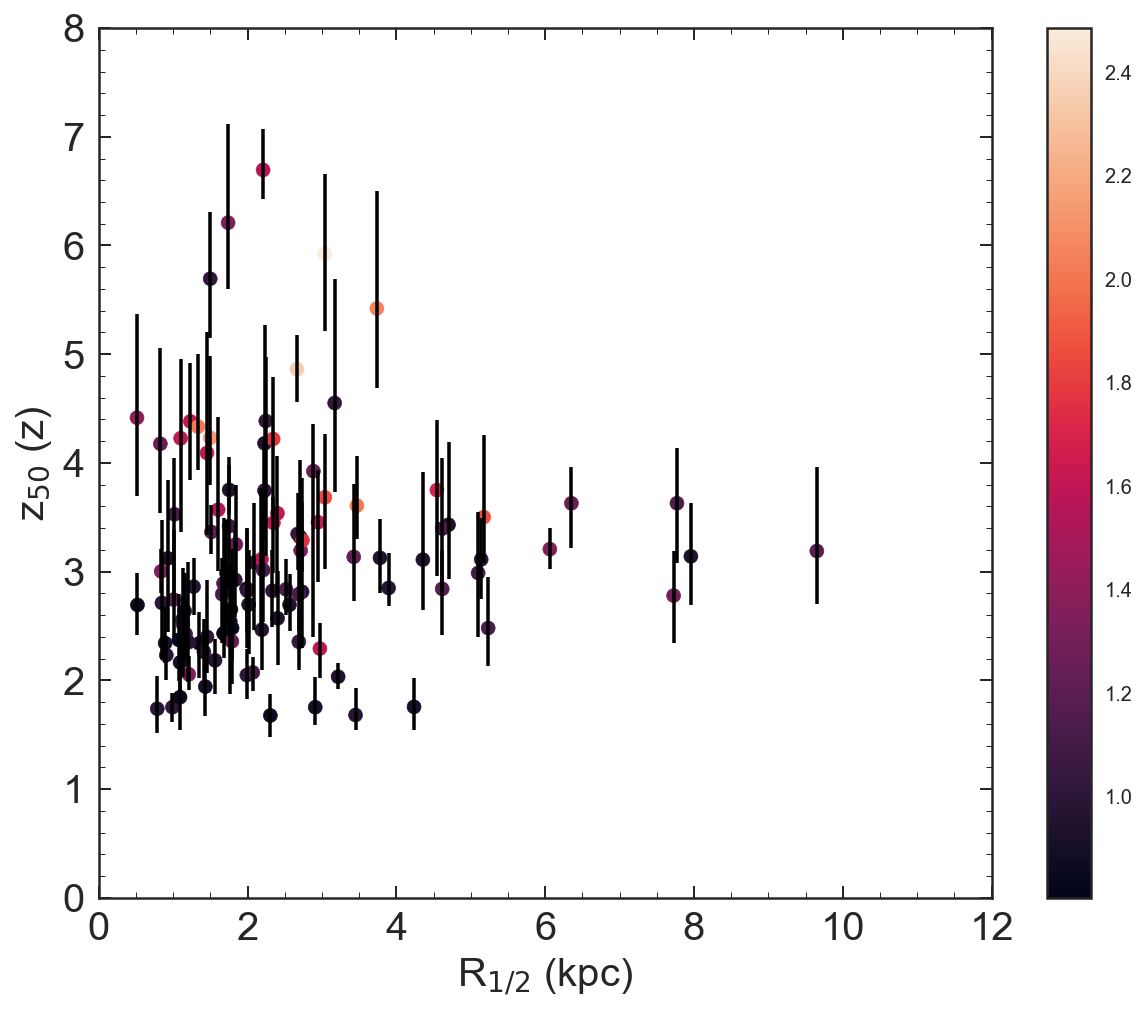

In [67]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')
mdb = morph_db.query('zgrism > 0.8 and log_ssfr  > -15')
# mdb = morph_db.query('1.8 < zgrism < 2.2 and log_ssfr  > -15')

inout = []
for i in mdb.index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            if (mdb.z_50_hci[i][2*ii+1] - mdb.z_50_hci[i][2*ii]) /2  < 1:
                inout.append('i')
            else:
                inout.append('o')
        
mdb['inout'] = inout
mdb = mdb.query('inout == "i"')

plt.figure(figsize=[10,8])

for i in mdb.index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            plt.errorbar(mdb.Reff[i],mdb.z_50[i], 
                 yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]], fmt='ko',
                        markersize=1)
plt.scatter(mdb.Reff, mdb.z_50, marker='o', c = mdb.zgrism)

# plt.hexbin(mdb.Reff, mdb.z_50, cmap = cmap)
# plt.scatter(sfdb.Reff,sfdb.z50, marker = '*',c = sfdb.log_ssfr, s =100)
plt.colorbar()

plt.xlabel('R$_{1/2}$ (kpc)', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(0,12)
plt.ylim(0,8)
# plt.savefig('../plots/morph/z_50_r.png', bbox_inches = 'tight')

# plots for presentation

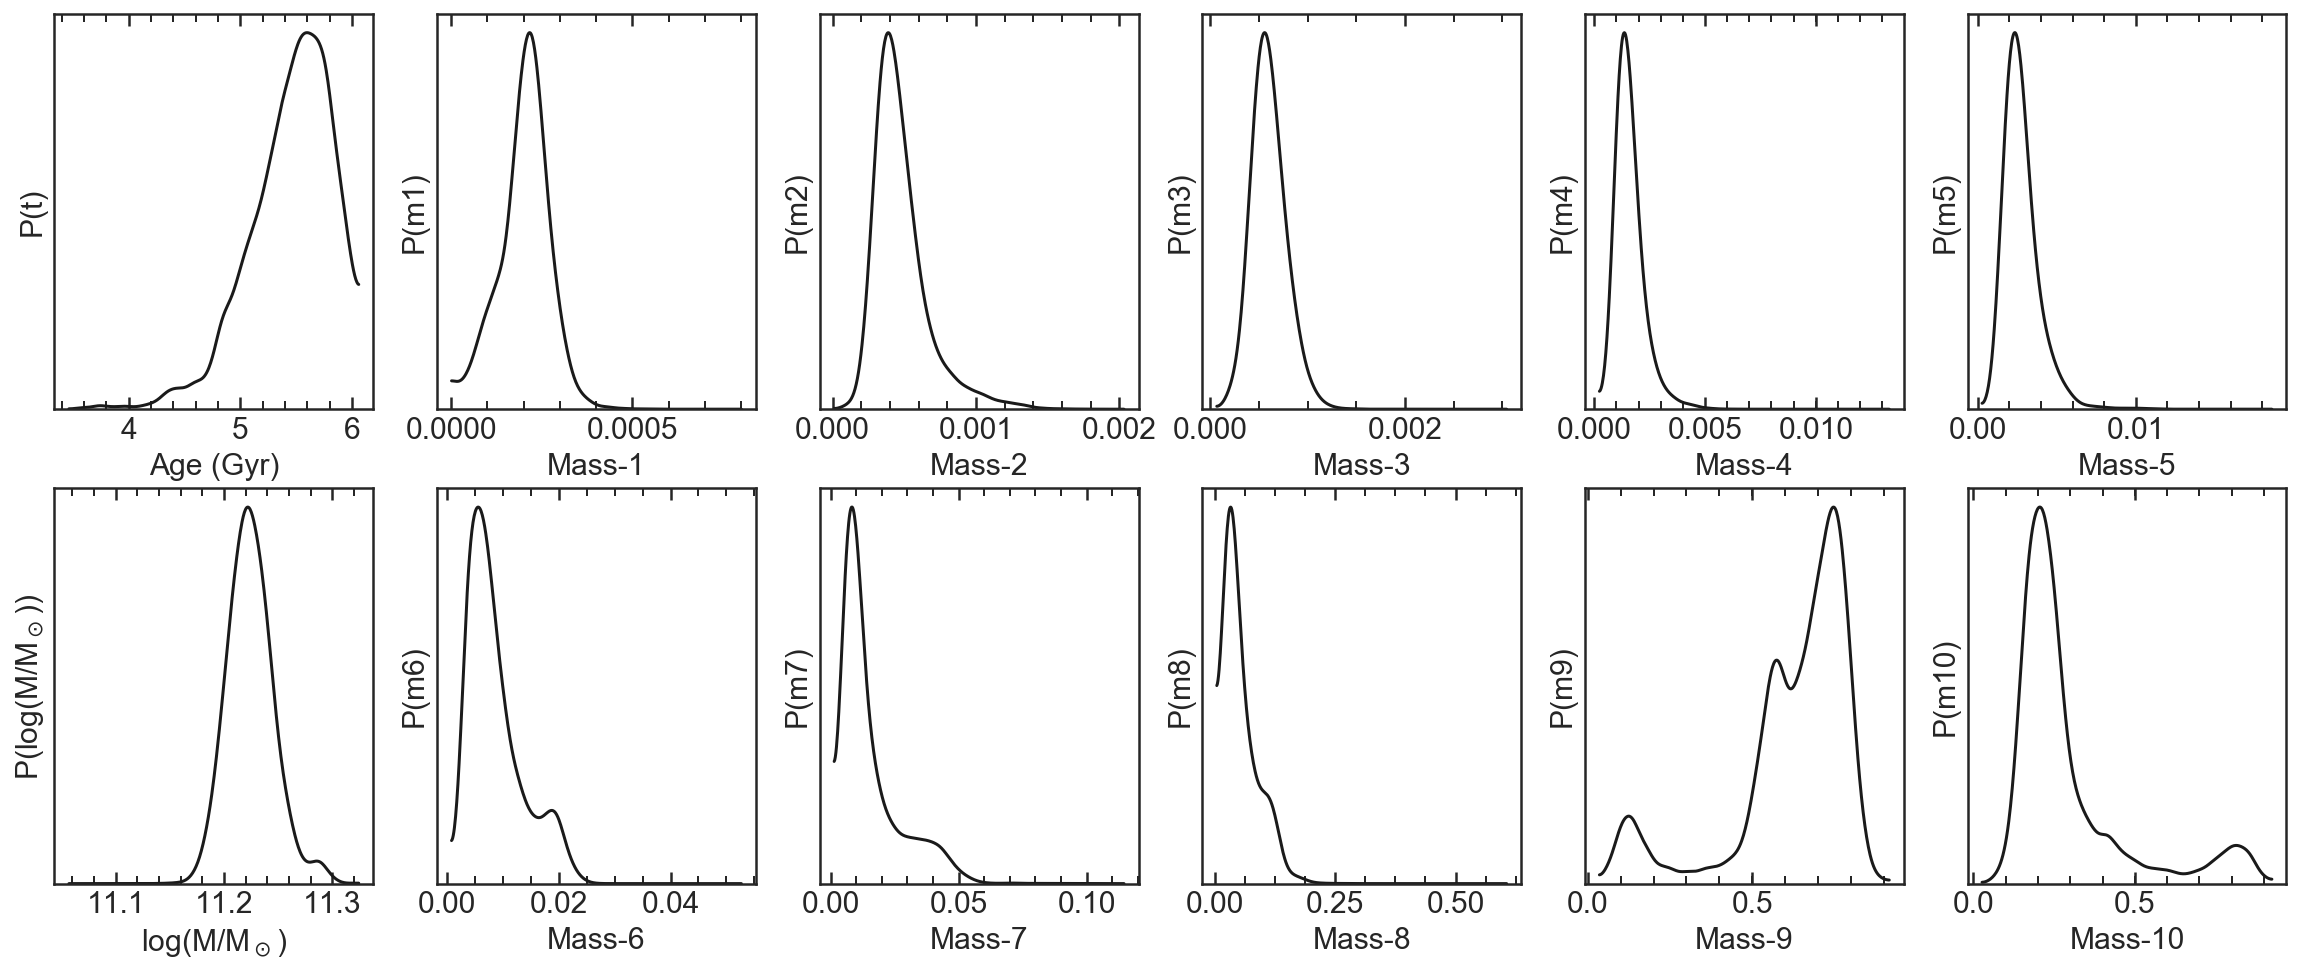

In [361]:
def plot_posterior(field, galaxy, param, x_name, y_name):
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, param))

    plt.plot(z,pz,'k')
    plt.xlabel('{0}'.format(x_name), fontsize=15)
    plt.ylabel('P({0})'.format(y_name), fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim(0,max(pz)*1.05)
    plt.yticks([])

params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'lm', 'm6', 'm7', 'm8', 'm9', 'm10']
x_name = ['Age (Gyr)', 'Mass-1', 'Mass-2', 'Mass-3', 'Mass-4', 'Mass-5', 'log(M/M$_\odot$)', 'Mass-6', 'Mass-7', 'Mass-8', 'Mass-9', 
          'Mass-10']
y_name = ['t', 'm1', 'm2', 'm3', 'm4', 'm5', 'log(M/M$_\odot$)', 'm6', 'm7', 'm8', 'm9', 'm10']

gs = gridspec.GridSpec(2,6)
plt.figure(figsize=[20,8])

row = 0
col = 0
for i in range(len(params)):
    plt.subplot(gs[row, col])
    plot_posterior('GND', 37813, params[i], x_name[i], y_name[i])
    col += 1
    if i == 5:
        row =1 
        col = 0
plt.savefig('../plots/GND_37813_post.png',bbox_inches = 'tight')


In [3]:
sfh = Rescale_sfh('GND', 37813)

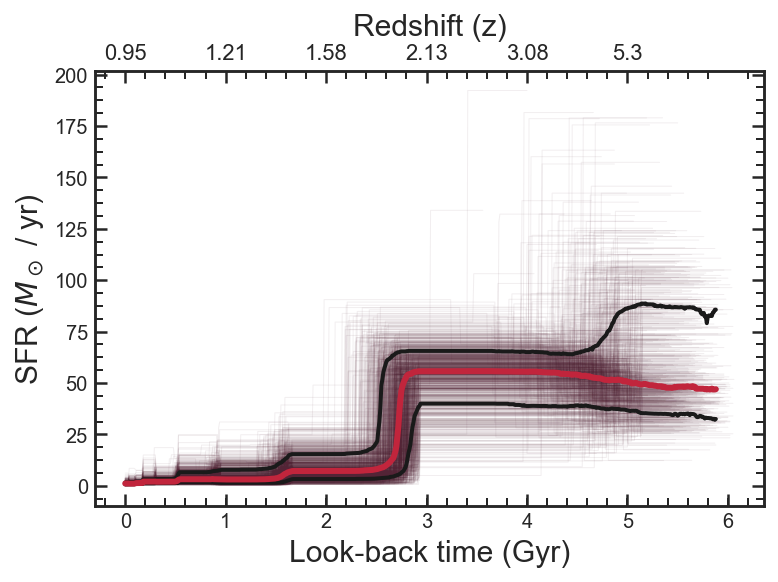

In [410]:
grow = mdb.query('id == 37813')

isfhl = interp1d(sfh.LBT,sfh.SFH_16)
isfhh = interp1d(sfh.LBT,sfh.SFH_84)

ax1 = plt.subplot()
ax2 = ax1.twiny()

ax1.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
ax1.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax1.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
ax1.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_all_sfh.png',bbox_inches = 'tight')

# ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
# ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

# for i in range(len(grow.t_50_hci.values[0])//2):
#     hdr = np.linspace(grow.t_50_hci.values[0][2*i],grow.t_50_hci.values[0][2*i+1])

#     ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
#     ax1.vlines(grow.t_50_hci.values[0][2*i],isfhl(grow.t_50_hci.values[0][2*i]),isfhh(grow.t_50_hci.values[0][2*i]), 
#                color = 'k', linewidth = 1, zorder = 8)
#     ax1.vlines(grow.t_50_hci.values[0][2*i+1],isfhl(grow.t_50_hci.values[0][2*i+1]),isfhh(grow.t_50_hci.values[0][2*i+1]), 
#                color = 'k', linewidth = 1, zorder = 8)

# ax1.vlines(grow.t_q.values[0],isfhl(grow.t_q.values[0]),isfhh(grow.t_q.values[0]), color = '#4E7577', linewidth = 2, zorder = 11)
# ax1.vlines(grow.t_q.values[0],isfhl(grow.t_q.values[0]),isfhh(grow.t_q.values[0]), color = 'k', linewidth = 4, zorder = 10)

# for i in range(len(grow.t_q_hci.values[0])//2):
#     hdr = np.linspace(grow.t_q_hci.values[0][2*i],grow.t_q_hci.values[0][2*i+1])

#     ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = 'k', alpha=0.6, zorder = 8)
#     ax1.vlines(grow.t_q_hci.values[0][2*i],isfhl(grow.t_q_hci.values[0][2*i]),isfhh(grow.t_q_hci.values[0][2*i]), 
#                color = 'k', linewidth = 1, zorder = 8)
#     ax1.vlines(grow.t_q_hci.values[0][2*i+1],isfhl(grow.t_q_hci.values[0][2*i+1]),isfhh(grow.t_q_hci.values[0][2*i+1]), 
#                color = 'k', linewidth = 1, zorder = 8)

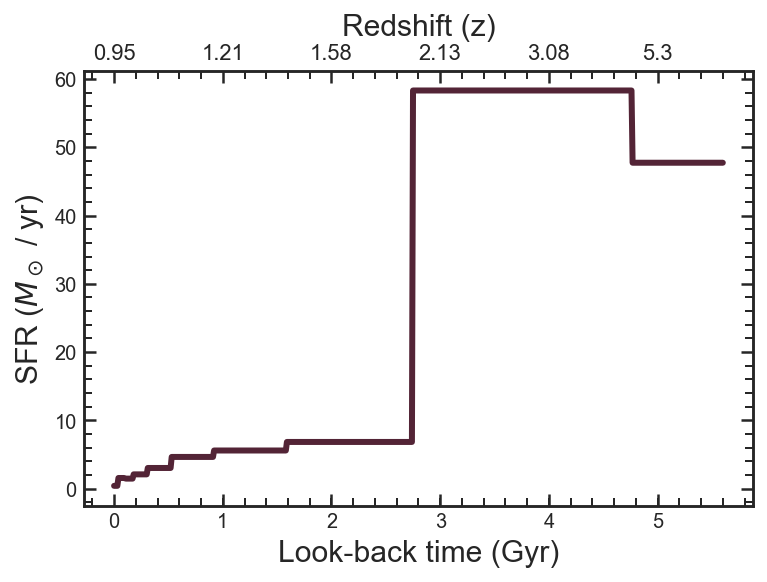

In [407]:
ax1 = plt.subplot()
ax2 = ax1.twiny()

ax1.plot(sfh.fulltimes, sfh.sfr_grid[0], color = '#532436', linewidth = 3)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_single_sfh.png',bbox_inches = 'tight')


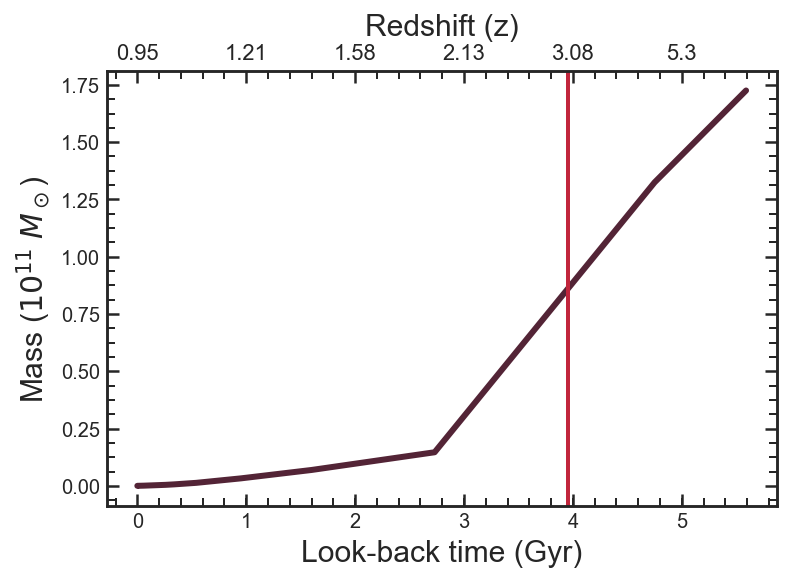

In [408]:
T=[0]
M=[0]
for i in range(len(sfh.fulltimes)-1):
    mass = sfh.sfr_grid[0][i+1] * (sfh.fulltimes[i+1] - sfh.fulltimes[i])
    if mass > 0:
        M.append(M[i] + mass)
        T.append(sfh.fulltimes[i])
    
t_50=interp1d(M/ M[-1], T)(0.5)

ax1 = plt.subplot()
ax2 = ax1.twiny()

ax1.plot(T, np.array(M)/100, color = '#532436', linewidth =3)
ax1.axvline(t_50,color = '#C1253C', linewidth =2)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('Mass ($10^{11}$ $M_\odot$)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_single_mass.png',bbox_inches = 'tight')


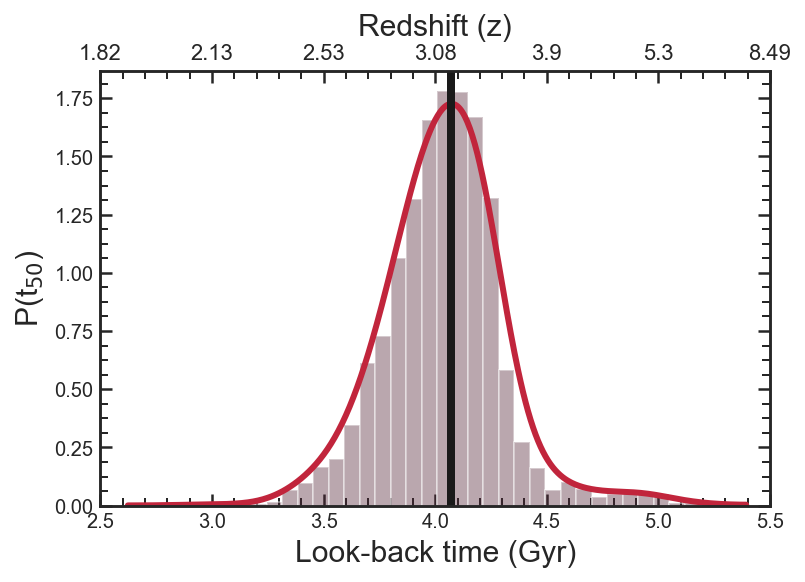

In [67]:
grow = mdb.query('id == 37813')

ax1 = plt.subplot()
ax2 = ax1.twiny()

sea.distplot(sfh.t_50_grid, hist_kws={'weights': sfh.weights}, kde=False, color = '#532436', norm_hist=True, bins=40, ax = ax1)
ax1.plot(x,np.array(px)*1.07 ,color = '#C1253C', linewidth = 3)
ax1.axvline(sfh.t_50,color = 'k', linewidth=4)
ax1.set_xlim(2.5,5.5)
ax2.set_xticks(np.arange(7))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(2.5,6.0,0.5) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('P(t$_{50}$)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('../plots/GND_37813_z_50.png',bbox_inches = 'tight')


In [60]:
sfh.z_50, sfh.t_50,np.arange(2.5,6.0,0.5)

(array(3.17263358),
 4.071991551884423,
 array([2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]))

In [58]:
np.round(lbt_to_z(np.arange(2.5,6.0,0.5) + cosmo.lookback_time(grow.zgrism.values[0]).value),2)

array([1.82, 2.13, 2.53, 3.08, 3.9 , 5.3 , 8.49])

In [57]:
age_to_z(Oldest_galaxy(grow.zgrism.values[0]) - np.arange(2.5,5.5,0.5)), age_to_z(Oldest_galaxy(grow.zgrism.values[0]) - sfh.t_50), 

(array([1.8223851 , 2.12754416, 2.52601124, 3.07533669, 3.89660369,
        5.30265061]), array(3.17260425))

In [24]:
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

def boot_to_posterior(values, weights):
    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(values, q, weights=weights)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(values, bins=bins, weights=weights,range=np.sort(span))
    n = norm_kde(n, 20.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

x,px = boot_to_posterior(sfh.t_50_grid, sfh.weights)

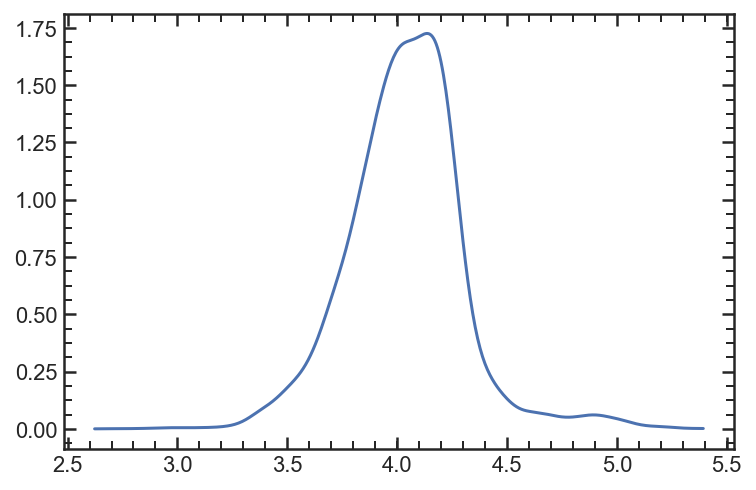

In [15]:
plt.plot(x,px)